### Density Estimation 

- Following [Manski et al.(2009)](https://www.tandfonline.com/doi/abs/10.1198/jbes.2009.0003)
- Three cases 
   - case 1. 3+ intervales with positive probabilities, to be fitted with a generalized beta distribution
   - case 2. exactly 2 adjacent intervals with positive probabilities, to be fitted with a triangle distribution 
   - case 3. __one or multiple__ intervals with equal probabilities, to be fitted with a uniform distribution
   

In [1]:
from scipy.stats import gamma
from scipy.stats import beta 
from scipy.stats import triang # new
from scipy.stats import uniform # new
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd

In [2]:
# We need that for the 90-10 ratio:
def quantile(x,quantiles):
    xsorted = sorted(x)
    qvalues = [xsorted[int(q * len(xsorted))] for q in quantiles]
    return qvalues

### Case 1. Generalized Beta Distribution

In [3]:
def GeneralizedBetaEst(bin,probs):
    """
    This fits a histogram with positive probabilities in at least 3 bins to a generalized beta distribution.
    Depending on if there is open-ended bin on either side with positive probability, 
       the estimator decides to estimate 2 or 4 parameters, respectively. 
       
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
                 
    returns
    -------
    moments:  ndarray of 2 or 4  
              2:  alpha and beta 
              4:  alpha, beta, lb, ub, e.g. lb=0 and ub=1 for a standard beta distribution
    """
    # n+1 bins and n probs, both are arrays
    if sum([probs[i]>0 for i in range(len(bin)-1)])<3:
        print("Warning: at least three bins with positive probs are needed")
        para_est=[]
    if sum(probs)!=1:
        print("probs need to sum up to 1")
        para_est=[]
    else:
        cdf = np.cumsum(probs)
        pprob=[i for i in range(len(bin)-1) if probs[i]>0]
        lb=bin[min(pprob)]
        print("lower bound is "+str(lb))
        ub=bin[max(pprob)+1]
        print("upper bound is "+str(ub))
        
        x0_2para = (2,1)
        x0_4para = (2,1,0,1) 
        def distance2para(paras2): # if there is no open-ended bin with positive probs 
            a,b=paras2
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        def distance4para(paras4): # if either on the left or right side one open-ended bin is with postive probs
            a,b,lb,ub=paras4
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        if lb==bin[0] and ub==bin[-1]:
            result = minimize(distance4para,x0_4para,
                                method='CG')
            if result['success']:
                para_est = result['x']
            else:
                para_est = []
            
        else:
            result = minimize(distance2para,x0_2para,
                                method='CG')
            para_est = result['x']
            if result['success']:
                para_est = result['x']
                scale = ub-lb
                para_est = np.concatenate([para_est,
                                          np.array([lb,scale])])
            else:
                para_est = []
        return para_est   # could be 2 or 4 parameters 

In [4]:
def GeneralizedBetaStats(a,b,lb,ub):
    """
    This function computes the moments of a generalized beta distribution, mean and variance for now. 
    
    parameters
    ----------
    a, b, lb, ub: floats #changed to a,b instead of alpha and beta
    
    returns
    -------
    dict:  2 keys
           mean, float 
           variance, float
           standard deviation, float
           ratio 90 10, float
    """
    # lb=0 and ub=1 for a standard beta distribution
    mean = lb + (ub-lb)*a/(a+b)
    var = (ub-lb)**2*a*b/((a+b)**2*(a+b+1))
    std = np.sqrt(var)
    # ratio
    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    quantiles = quantile(x,[0.1, 0.9])
    iqr1090 = quantiles[0]/quantiles[1]
    return {"mean": mean,"variance":var, "std": std, "iqr1090": iqr1090}

### Case 2. Isosceles Triangle distribution

Two adjacent intervales $[a,b]$,$[b,c]$ are assigned probs $\alpha$ and $1-\alpha$, respectively. In the case of $\alpha<1/2$, we need to solve parameter $t$ such that $[b-t,c]$ is the interval of the distribution. Denote the height of the trangle distribution $h$. Then following two restrictions need to satisfy

\begin{eqnarray}
\frac{t^2}{t+c-b} h = \alpha \\
(t+(c-b))h = 2
\end{eqnarray}

The two equations can solve $t$ and $h$

$$\frac{t^2}{(t+c-b)^2}=\alpha$$

$$t^2 = \alpha t^2 + 2\alpha t(c-b) + \alpha(c-b)^2$$

$$(1-\alpha) t^2 - 2\alpha(c-b) t - \alpha(c-b)^2=0$$

$$\implies t =\frac{2\alpha(c-b)+\sqrt{4\alpha^2(c-b)^2+4(1-\alpha)\alpha(c-b)^2}}{2(1-\alpha)} = \frac{\alpha(c-b)+(c-b)\sqrt{\alpha}}{(1-\alpha)}$$

$$\implies h = \frac{2}{t+c-b}$$

Rearrange to solve for c:
$$ \implies c = (t - b) - \frac{2}{h} $$
$$ \implies c = ub - \frac{2}{h} $$

In [5]:
def TriangleEst(bin,probs):
    """
    The function fits histograms with exactly two adjacent 
       bins with positive probabilitie to a triangular distribution.
    It genetes the bounds of the isoceles triangle distribution. 
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 3 keys
          lb: float, left bound 
          ub: float, right bound
          h:  float, height of the triangle
          c: float, mode
    
    """
    if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
        print("There are two bins with positive probs")
        pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
        if sum(pprobadj)>0:
            print('The two intervals are adjacent and not open-ended')
            min_i = min(pprobadj)
            #print(min_i)
            #print(probs[min_i])
            #print(probs[min_i+1])
            #print(pprobadj[0])
            #print(pprobadj[0]+2)
            #print(probs[min_i] > probs[min_i+1])
            #print(bin[pprobadj[0]])
            #print(bin[pprobadj[0]+2])
            if probs[min_i] > probs[min_i+1]:
                alf = probs[min_i+1]
                lb = bin[pprobadj[0]]
                scl = bin[pprobadj[0]+1]-bin[pprobadj[0]]
                t = scl*(alf/(1-alf) +np.sqrt(alf)/(1-alf))
                ub = bin[pprobadj[0]+1]+t 
                h = 2/(t+bin[pprobadj[0]+1]-bin[pprobadj[0]])
                c = ub - 2/h
            if probs[min_i] < probs[min_i+1]:
                alf = probs[min_i]
                ub = bin[pprobadj[0]+2]
                scl = bin[pprobadj[0]+2]-bin[pprobadj[0]+1]
                t = scl*(alf/(1-alf) + np.sqrt(alf)/(1-alf))
                lb = bin[pprobadj[0]+1]-t  
                h = 2/(t+bin[pprobadj[0]+2]-bin[pprobadj[0]+1])
                c = ub - 2/h
            if probs[min_i] == probs[min_i+1]:
                ub=bin[pprobadj[0]]
                lb=bin[pprobadj[0]+2]
                h = 2/(ub-lb)
                c = ub - 2/h
        else:
            lb = []
            ub = []
            h = []
            c = []
            print('Warning: the two intervals are not adjacent or are open-ended')
    return {'lb':lb,'ub':ub,"height":h,"mode":c}

#### pdf of a triangle distribution

\begin{eqnarray}
f(x)= & 1/2(x-lb) \frac{x-lb}{(ub+lb)/2}h \quad \text{if } x <(lb+ub)/2 \\
& = 1/2(ub-x) \frac{ub-x}{(ub+lb)/2}h \quad \text{if } x \geq(lb+ub)/2
\end{eqnarray}

\begin{eqnarray}
& Var(x) & = \int^{ub}_{lb} (x-(lb+ub)/2)^2 f(x) dx \\
& & = 2 \int^{(ub+lb)/2}_{lb} (x-(lb+ub)/2)^2 (x-lb) \frac{x-lb}{(ub+lb)/2}h dx
\end{eqnarray}



In [6]:
def TriangleStats(lb,ub,c):
    """
    parameters
    ----------
    lb and ub:  float, left and right bounds of the triangle distribution
    c : float, mode
    
    returns
    -------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance
           std, float 
           irq1090, float  
    """
    
    mean = (lb+ub)/2
    var = (lb**2+ub**2+(lb+ub)**2/4-lb*(lb+ub)/2-ub*(lb+ub)/2-lb*ub)/18
    std = np.sqrt(var)
    x = np.linspace(triang.ppf(0.01, c, lb, ub), triang.ppf(0.99, c, lb, ub), 100)
    quantiles = quantile(x,[0.1, 0.9])
    iqr1090 = quantiles[0]/quantiles[1]
    return {"mean": mean,"variance":var, "std": std, "iqr1090": iqr1090}

### Case 3. Uniform Distribution

In [7]:
def UniformEst1bin(bin,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """
    pprob=[i for i in range(len(bin)-1) if probs[i]>0]
    if len(pprob)==1:
        if pprob[0]!=0 and pprob[0]!=len(bin)-1:
            lb = bin[pprob[0]]
            ub = bin[pprob[0]+1]
        else:
            lb=[]
            ub=[]
    else:
        lb=[]
        ub=[]
    return {"lb":lb,"ub":ub}

In [8]:
# New function: Takes into account that many bins have the same probability
def UniformEst(bins,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    paramters
    ---------
    bins:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """    
    pos_bins = []
    # find non zero positions
    pos_entry = np.argwhere(probs!=0)
            
    for i in pos_entry:
        pos_bins.append(probs[i])
    pos_bins = np.hstack(pos_bins)   # clean    

    if len(pos_entry)>1:
        for i in range(len(pos_entry)-1) :
            if pos_entry[i+1] - pos_entry[i] !=1:
                pos_bins = [] 
               
    if len(pos_bins)==1:
        print('length pos bins is 1')
        lb = bins[pos_entry[0]]
        lb = lb[0] # into float
        ub = bins[pos_entry[0] + 1]
        ub = ub[0] # into float
    if len(pos_bins)>1:
        print('length pos bins is > 1')
        lb = bins[pos_entry[0]]
        lb = lb[0] # into float
        ub = bins[pos_entry[0] + len(pos_bins)] 
        ub = ub[0] # into float
    if len(pos_bins)==0:
        lb=[]
        ub=[]

    return {"lb":lb,"ub":ub}

In [9]:
def UniformStats(lb,ub):
    """
    The function computes the moment of a uniform distribution.
    
    parameters
    ----------
    lb and ub, floats, left and right bounds of uniform distribution
    
    returns
    --------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance 
           std, float 
           irq1090, float  
    """
    
    if lb and ub: ## empty list is True
        mean = (lb+ub)/2
        var = (ub-lb)**2/12
        std = np.sqrt(var)
        x = np.linspace(uniform.ppf(lb),uniform.ppf(ub), 100)
        p10 = np.percentile(x, 10)
        p90 = np.percentile(x, 90)
        iqr1090 = p90/p10
    else:
        mean=[]
        var=[]
        std = []
        iqr1090 = []
    return {"mean": mean,"variance":var, "std": std, "iqr1090": iqr1090}

### Test using made-up data

In [10]:
## test 1: GenBeta Dist
sim_bins= np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs=np.array([0,0.5,0.05,0.05,0.4])
GeneralizedBetaEst(sim_bins,sim_probs)

lower bound is 0.2
upper bound is 1.2


[]

In [11]:
## test 2: Triangle Dist
sim_bins2 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs2=np.array([0,0.2,0.8,0,0])
TriangleEst(sim_bins2,sim_probs2)

There are two bins with positive probs
The two intervals are adjacent and not open-ended


{'lb': 0.1743769410125095,
 'ub': 0.5,
 'height': 6.142071161111579,
 'mode': 0.1743769410125095}

In [12]:
## test 3: Uniform Dist with one interval
sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3 = np.array([0,0,1,0,0])
para_est= UniformEst(sim_bins3,sim_probs3)
print(para_est)
UniformStats(para_est['lb'],para_est['ub']) 

length pos bins is 1
{'lb': 0.32, 'ub': 0.5}


{'mean': 0.41000000000000003,
 'variance': 0.0026999999999999997,
 'std': 0.05196152422706632,
 'iqr1090': 1.4260355029585798}

In [13]:
## test 4: Uniform Dist with multiple adjacent bins with same probabilities 
sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3=np.array([0.2,0.2,0.2,0.2,0.2])
para_est= UniformEst(sim_bins3,sim_probs3)
print(para_est)
UniformStats(para_est['lb'],para_est['ub']) 

length pos bins is > 1
{'lb': 0.0, 'ub': 1.2}


{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}

In [14]:
## test 5: Uniform Dist with multiple non-adjacent bins with equal probabilities
sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3=np.array([0,0.5,0,0.5,0])
para_est= UniformEst(sim_bins3,sim_probs3)
print(para_est)
UniformStats(para_est['lb'],para_est['ub']) 

{'lb': [], 'ub': []}


{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}

### Test with simulated data from known distribution 
- we simulate data from a true beta distribution with known parameters
- then we estimate the parameters with our module and see how close it is with the true parameters 

lower bound is 0.10000142673068149
upper bound is 2.0999955324423896
Estimated parameters [0.56598356 0.66865328 0.06957842 2.10000604]
Estimated moments: {'mean': 1.00036925323809, 'variance': 0.4580305073532272, 'std': 0.6767795116234143, 'iqr1090': 0.11158024192322116}
True simulated moments: 1.0039920660484172 0.4534096361690509 0.6733569901389982


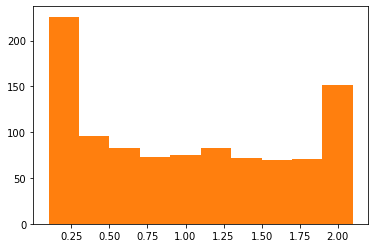

In [15]:
## simulate a generalized distribution
sim_n=1000
true_alpha,true_beta,true_loc,true_scale=0.5,0.6,0.1,2
sim_data = beta.rvs(true_alpha,true_beta,
                    loc=true_loc,
                    scale=true_scale,
                    size=sim_n)
sim_bins2=plt.hist(sim_data)[1]
sim_probs2=plt.hist(sim_data)[0]/sim_n
sim_est=GeneralizedBetaEst(sim_bins2,sim_probs2)

print('Estimated parameters',sim_est)

print('Estimated moments:',GeneralizedBetaStats(sim_est[0],
                          sim_est[1],
                          sim_est[2],
                          sim_est[3]))

print('True simulated moments:',
      np.mean(sim_data),
     np.std(sim_data)**2,
     np.std(sim_data)
     )

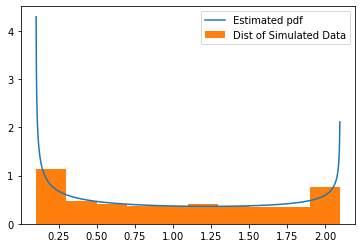

In [16]:
## plot the estimated generalized beta versus the histogram of simulated data drawn from a true beta distribution 
sim_x = np.linspace(true_loc,true_loc+true_scale,sim_n)
sim_pdf=beta.pdf(sim_x,sim_est[0],sim_est[1],loc=true_loc,scale=true_scale)
plt.plot(sim_x,sim_pdf,label='Estimated pdf')
plt.hist(sim_data,density=True,label='Dist of Simulated Data')
plt.legend(loc=0)

In [17]:
## This is the synthesized density estimation function
def SynDensityStat(bin,probs):
    """
    Synthesized density estimate module:
    It first detects the shape of histograms
    Then accordingly invoke the distribution-specific tool.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    -------
    moments: dict with 2 keys (more to be added in future)
            mean: empty or float, estimated mean 
            variance:  empty or float, estimated variance 
            std: empty or float, estimated standard deviation 
            irq1090: empty or float, estimated irq1090 
    
    """
    if sum(probs)==1:
        print("probs sum up to 1")
        ## Check if all bins have the same probability (special case for which we need Uniform and not Beta distributions)
        all_equal = 0
        pos_bin = []
        # find non zero positions
        pos_entry = np.argwhere(probs!=0)
            
        for i in pos_entry:
            pos_bin.append(probs[i])
        pos_bin = np.hstack(pos_bin)   # clean    

        if len(pos_entry)>1:
            for i in range(len(pos_entry)-1) :
                if pos_entry[i+1] - pos_entry[i] !=1:
                    pos_bin = [] 
                
        if len(pos_bin)!=0:
            if np.all(pos_bin == pos_bin[0]):
                all_equal = 1
                
                
        ## Beta distributions 
        if sum([probs[i]>0 for i in range(len(bin)-1)])>=3 and all_equal == 0:
            print("at least three bins with positive probs")
            para_est=GeneralizedBetaEst(bin,probs)
            if len(para_est)==4:
                print('4 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],para_est[2],para_est[3])
            if len(para_est)==2:
                print('2 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],0,1)
        ## Triangle distributions
        if sum([probs[i]>0 for i in range(len(bin)-1)])==2 and all_equal == 0:
            #print("There are two bins with positive probs")
            pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
            if sum(pprobadj)>0:
                #print('The two intervals are adjacent and not open-ended')
                para_est=TriangleEst(bin,probs)
                return TriangleStats(para_est['lb'],para_est['ub'], para_est['mode'])
        ## Uniform distributions
        if sum([probs[i]>0 for i in range(len(bin)-1)])==1:
            print('Only one interval with positive probs')
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])
        if all_equal == 1:
            print("all bins have the same prob")
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])            
        else:
            return {"mean":[],"variance":[], "std":[], "iqr1090":[]}
    else:
        return {"mean":[],"variance":[], "std":[], "iqr1090":[]}

In [18]:
## testing the synthesized estimator function using an arbitrary example created above
SynDensityStat(sim_bins2,sim_probs2)['variance']
SynDensityStat(sim_bins2,sim_probs2)['iqr1090']

probs sum up to 1
at least three bins with positive probs
lower bound is 0.10000142673068149
upper bound is 2.0999955324423896
4 parameters
probs sum up to 1
at least three bins with positive probs
lower bound is 0.10000142673068149
upper bound is 2.0999955324423896
4 parameters


0.11158024192322116

In [19]:
### loading probabilistic data  
IndSPF=pd.read_stata('../SurveyData/SPF/individual/InfExpSPFProbIndQ.dta')   
# SPF inflation quarterly 
# 2 Inf measures: CPI and PCE
# 2 horizons: y-1 to y  and y to y+1

In [20]:
## survey-specific parameters 
nobs=len(IndSPF)
SPF_bins=np.array([-10,0,0.5,1,1.5,2,2.5,3,3.5,4,10])
print("There are "+str(len(SPF_bins)-1)+" bins in SPF")

There are 10 bins in SPF


In [21]:
##############################################
### attention: the estimation happens here!!!!!
###################################################

#IndSPF['PRCCPIMean0']='nan'   # CPI from y-1 to y 
#IndSPF['PRCCPIVar0']='nan'    
#IndSPF['PRCCPIMean1']='nan'  # CPI from y to y+1  
#IndSPF['PRCCPIVar1']='nan'
#IndSPF['PRCPCEMean0']='nan' # PCE from y-1 to y
#IndSPF['PRCPCEVar0']='nan'
#IndSPF['PRCPCEMean1']='nan' # PCE from y to y+1
#IndSPF['PRCPCEVar1']='nan'


## creating positions 
index  = IndSPF.index
columns=['PRCCPIMean0','PRCCPIVar0', 'PRCCPIStd0','PRCCPIIqr10900',
         'PRCCPIMean1','PRCCPIVar1','PRCCPIStd1','PRCCPIIqr10901',
         'PRCPCEMean0','PRCPCEVar0','PRCPCEStd0','PRCPCEIqr10900',
         'PRCPCEMean1','PRCPCEVar1','PRCPCEStd1','PRCPCEIqr10901']
IndSPF_moment_est = pd.DataFrame(index=index,columns=columns)

## Invoking the estimation

for i in range(nobs):
    print(i)
    ## take the probabilities (flip to the right order, normalized to 0-1)
    PRCCPI_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCCPI_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    PRCPCE_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCPCE_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    if not np.isnan(PRCCPI_y0).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y0)
        if len(stats_est)>0:
            IndSPF_moment_est['PRCCPIMean0'][i]=stats_est['mean']
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIVar0'][i]=stats_est['variance']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCCPIStd0'][i]=stats_est['std']
            print(stats_est['std'])
            IndSPF_moment_est['PRCCPIIqr10900'][i]=stats_est['iqr1090']
            print(stats_est['iqr1090'])            
    if not np.isnan(PRCCPI_y1).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y1)
        if len(stats_est):
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCCPIVar1'][i]=stats_est['variance']
            print(stats_est['std'])
            IndSPF_moment_est['PRCCPIStd1'][i]=stats_est['std']
            print(stats_est['iqr1090'])
            IndSPF_moment_est['PRCCPIIqr10901'][i]=stats_est['iqr1090']
    if not np.isnan(PRCPCE_y0).any():
        if len(stats_est)>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y0)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean0'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar0'][i]=stats_est['variance']
            print(stats_est['std'])
            IndSPF_moment_est['PRCPCEStd0'][i]=stats_est['std']
            print(stats_est['iqr1090'])
            IndSPF_moment_est['PRCPCEIqr10900'][i]=stats_est['iqr1090']
    if not np.isnan(PRCPCE_y1).any():
        if len(stats_est)>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y1)
            print(stats_est)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar1'][i]=stats_est['variance']
            print(stats_est['std'])
            IndSPF_moment_est['PRCPCEStd1'][i]=stats_est['std']
            print(stats_est['iqr1090'])
            IndSPF_moment_est['PRCPCEIqr10900'][i]=stats_est['iqr1090']

0
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
1.7864800540885444
0.015267747488349866
0.12356272693798023
0.1285285506029574
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.19901505366719574
[]
[]
[]
[]
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
2
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
3
[0.  0.  0.  0.  0.  0.2 0.7 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.2 0.6 0.2 0.  0

4 parameters
{'mean': 1.8804082035340497, 'variance': 0.08258985653110307, 'std': 0.28738450990111325, 'iqr1090': 0.2855795804165475}
1.8804082035340497
0.08258985653110307
0.28738450990111325
0.2855795804165475
14
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.05 0.25 0.4  0.2  0.05 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.05 0.25 0.4  0.2  0.05 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.4999997334707362
0.022979669905026805
0.15159046772481047
0.3065583307503693
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.5601622349359254
0.16600708338171444
0.4074396683948612
0.2303336490573272
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2824555067939838
0.007298018244441713
0.08542843931877553
0.2985584596195581
probs sum up to

2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.0, 'ub': 3.0}
{'mean': 2.0, 'variance': 0.3333333333333333, 'std': 0.5773502691896257, 'iqr1090': nan}
2.0
0.3333333333333333
0.5773502691896257
nan
24
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
1.8000209604391018
0.009210406034102227
0.09597086033844975
0.16841617858401922
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
1.8000209604391018
0.009210406034102227
0.09597086033844975
0.16841617858401922
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.19901505366719574
probs sum up to 1
at least three bi

4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.26941934212116175}
1.5
0.0
0.0
0.26941934212116175
37
[0.   0.   0.   0.   0.05 0.15 0.6  0.2  0.   0.  ]
[0.   0.   0.   0.   0.05 0.3  0.45 0.2  0.   0.  ]
[0.   0.   0.   0.   0.05 0.15 0.6  0.2  0.   0.  ]
[0.   0.   0.   0.   0.05 0.3  0.45 0.2  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
4 parameters
1.8110644321839924
0.005185879866428138
0.0720130534446925
0.39911073765885224
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
4 parameters
1.7872017752172646
0.008958050345315974
0.09464697747586012
0.2627954889431254
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2582725900762168
0.009831798715235299
0.09915542705891241
0.21703075091763166
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parame

[0.  0.  0.  0.  0.  0.3 0.6 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.7 0.2 0.  0. ]
[0.  0.  0.  0.  0.  0.3 0.6 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.7 0.2 0.  0. ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
1.7335276081490893
0.00562507267396454
0.07500048449153206
0.3315366736265918
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
{'mean': 1.7335276081490893, 'variance': 0.00562507267396454, 'std': 0.07500048449153206, 'iqr1090': 0.3315366736265918}
1.7335276081490893
0.00562507267396454
0.07500048449153206
0.3315366736265918
55
[0.   0.   0.   0.02 0.1  0.5  0.35 0.03 0.   0.  ]
[0.   0.   0.   0.05 0.25 0.35 0.3  0.05 0.   0.  ]
[0.   0.   0.   0.02 0.1  0.5  0.35 0.03 0.   0.  ]
[0.   0.   0.   0.05 0.25 0.35 0.3  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 para

4 parameters
1.5
0.0
0.0
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.3996260172112216
69
[0.   0.   0.02 0.06 0.1  0.25 0.3  0.15 0.1  0.02]
[0.   0.05 0.02 0.06 0.12 0.2  0.25 0.15 0.12 0.03]
[0.   0.   0.02 0.06 0.1  0.25 0.3  0.15 0.1  0.02]
[0.   0.05 0.02 0.06 0.12 0.2  0.25 0.15 0.12 0.03]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
4 parameters
2.52780039820201
0.43427588494230734
0.658996119064678
0.3032129242514152
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
2.603493325606439
0.7598202129662497
0.8716766676734268
0.2910660407899651
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
4 parameters
2.482538206210597
0.4276991516274697
0.6539871188543928
0.29840914165420723
probs sum up to 1
at least three bins with positi

4 parameters
1.749970996504733
0.1474022112319424
0.38392995615338793
0.43096383316928316
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.749970996504733
0.1474022112319424
0.38392995615338793
0.43096383316928316
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
{'mean': 1.9999978021207263, 'variance': 0.14942562711182703, 'std': 0.38655611120745076, 'iqr1090': 0.3693288961289776}
1.9999978021207263
0.14942562711182703
0.38655611120745076
0.3693288961289776
80
[0.   0.   0.   0.1  0.2  0.4  0.25 0.05 0.   0.  ]
[0.   0.   0.   0.1  0.2  0.35 0.25 0.1  0.   0.  ]
[0.   0.   0.   0.1  0.2  0.4  0.25 0.05 0.   0.  ]
[0.   0.   0.   0.1  0.2  0.35 0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.7439071865387212
0.08096854516359457
0.2845497235345601
0.22179866613603488
probs sum up to 1


4 parameters
2.645957389372777
0.32312975303588237
0.5684450307953113
0.28386624844919356
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.7674067704346572
0.060851433291568134
0.2466808328418893
0.2827272644980876
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
{'mean': 2.054189384733128, 'variance': 0.28136504049315286, 'std': 0.5304385360182203, 'iqr1090': 0.25919091444246095}
2.054189384733128
0.28136504049315286
0.5304385360182203
0.25919091444246095
94
[0.  0.  0.  0.  0.1 0.5 0.4 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.5 0.4 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.5 0.4 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.5 0.4 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.26941934212116175
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 paramet

4 parameters
1.5
0.0
0.0
0.23684195257779764
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.23684195257779764
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.23684195257779764}
1.5
0.0
0.0
0.23684195257779764
107
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
108
[0.01 0.01 0.01 0.01 0.1  0.68 0.15 0.01 0.01 0.01]
[0.01 0.01 0.01 0.05 0.15 0.5  0.2  0.05 0.01 0.01]
[0.01 0.01 0.01 0.01 0.1  0.68 0.15 0.01 0.01 0.01]
[0.01 0.01 0.01 0.05 0.15 0.5  0.2  0.05 0.01 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2619518318857565
0.09612302102796708
0.3100371284668452
0.11144252465182625
probs sum up to 1
at lea

[0.   0.   0.   0.02 0.4  0.5  0.08 0.   0.   0.  ]
[0.   0.   0.   0.02 0.4  0.5  0.08 0.   0.   0.  ]
[0.   0.   0.   0.02 0.4  0.5  0.08 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5320339318671472
0.02258757708012595
0.1502916400872848
0.3302109689947082
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5320339318671472
0.02258757708012595
0.1502916400872848
0.3302109689947082
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.4782178672952784
0.022216781150800367
0.14905294747438028
0.2985692941901717
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.4782178672952784, 'variance': 0.022216781150800367, 'std': 0.14905294747438028, 'iqr1090': 0.2985692941901717}
1.4782178672952784
0.022216781150800367
0.14905294747

[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.7 0.2 0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.5 0.1 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
1.7335276081490893
0.00562507267396454
0.07500048449153206
0.3315366736265918
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
1.8000209604391018
0.009210406034102227
0.09597086033844975
0.16841617858401922
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
0.07710969514083772
0.27768632508792673
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
{'mean': 2.680189805014032, 'variance': 0.07710969514083758, 'std': 0.27768632508792646, 'iqr1090': nan}
2.680189805014032
0.07710969514083758
0.27768632508792646
nan
139
[nan nan nan nan nan nan nan nan nan nan]
[nan nan

4 parameters
{'mean': 1.4846055970123042, 'variance': 0.1722526687292563, 'std': 0.4150333344796009, 'iqr1090': 0.20483682399622047}
1.4846055970123042
0.1722526687292563
0.4150333344796009
0.20483682399622047
151
[0.  0.  0.  0.5 0.4 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.4 0.3 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.5 0.4 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.4 0.3 0.3 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.1793413821811103
0.011472921843826903
0.10711172598659263
0.13087750165707468
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2297072290244535
0.023007331855350505
0.15168167936619933
0.11407077568423006
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
1.0729620599644432
0.06106547044579695
0.24711428620336168
0.16710913264602026
probs sum up to 1
at least three bins with positive 

4 parameters
1.5
0.0
0.0
0.4619423105121498
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.6863003214969705
0.0589176292767586
0.24272953935761218
0.4509684470418938
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499898357061485
0.004049549052666394
0.0636360672312989
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
{'mean': 1.6570587621411708, 'variance': 0.07393058367885796, 'std': 0.2719017905032219, 'iqr1090': 0.3980811938470935}
1.6570587621411708
0.07393058367885796
0.2719017905032219
0.3980811938470935
165
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.01 0.05 0.4  0.45 0.08 0.01 0.   0.  ]
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.01 0.05 0.4  0.45 0.08 0.01 0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjac

4 parameters
1.5
0.0
0.0
0.5790707284082698
[]
[]
[]
[]
176
[0.   0.   0.   0.1  0.15 0.5  0.15 0.1  0.   0.  ]
[0.   0.05 0.1  0.15 0.4  0.15 0.1  0.05 0.   0.  ]
[0.   0.   0.   0.1  0.15 0.5  0.15 0.1  0.   0.  ]
[0.   0.05 0.1  0.15 0.4  0.15 0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.750002231450703
0.0680425683133701
0.26084970445329264
0.2549448290025044
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.7499984535301791
0.3931692128052274
0.6270320668077729
0.24414223261689796
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.4999967776235135
0.05533798352272341
0.23524026764719386
0.4044397607524297
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
{'mean': 1.500002975267604, 'variance': 0.12096456589043574, 'std

4 parameters
2.4252863535212157
0.25908218271924804
0.509001161805401
0.8465646373229853
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.328800008354964
0.8702627413580825
0.9328787388284088
0.8396278110520473
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.5885275844381077, 'variance': 0.5852864242960729, 'std': 0.7650401455453648, 'iqr1090': 0.8030629354800771}
2.5885275844381077
0.5852864242960729
0.7650401455453648
0.8030629354800771
187
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
188
[0.   0.   0.   0.   0.1  0.65 0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.2  0.45 0.2  0.05 0.  ]
[0.   0.   0.   0.   0.1  

4 parameters
1.5
0.0
0.0
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499976805578967
0.008343683623971377
0.09134376620203141
0.23714926302365408
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
{'mean': 2.052758056251845, 'variance': 0.0509235781252197, 'std': 0.22566253150494367, 'iqr1090': nan}
2.052758056251845
0.0509235781252197
0.22566253150494367
nan
199
[0.02 0.03 0.04 0.1  0.2  0.35 0.18 0.05 0.02 0.01]
[0.01 0.03 0.05 0.16 0.2  0.3  0.14 0.06 0.03 0.02]
[0.02 0.03 0.04 0.1  0.2  0.35 0.18 0.05 0.02 0.01]
[0.01 0.03 0.05 0.16 0.2  0.3  0.14 0.06 0.03 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.061847404687061
0.4840692117

4 parameters
1.8594091291220707
0.03507148782218577
0.18727383111952872
0.4282759784358887
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
212
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.7  0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.7  0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.3015072017609675
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.38604984752346155
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2664723918509107
0.00562507267396454
0.07500048449153206
0.3315366736265918
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.2909826174923622, 'variance': 0.0052793912

4 parameters
1.4831574601450124
0.03409303008318277
0.1846429800538942
0.22412460299416348
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.632743710359466
0.10947731760008081
0.330873567394074
0.32559795348854914
222
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
[0.   0.05 0.1  0.15 0.4  0.15 0.1  0.05 0.   0.  ]
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
[0.   0.05 0.1  0.15 0.4  0.15 0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5000018052421775
0.08919167301095413
0.29864974972524944
0.31233814773618884
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.7499984535301791
0.3931692128052274
0.6270320668077729
0.24414223261689796
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5000018052421775
0.08919167

4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.2409242039342423}
1.5
0.0
0.0
0.2409242039342423
234
[0.   0.02 0.08 0.1  0.2  0.25 0.3  0.05 0.   0.  ]
[nan nan nan nan nan nan nan nan nan nan]
[0.   0.02 0.08 0.1  0.2  0.25 0.3  0.05 0.   0.  ]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
2.120284357437771
0.4625761753291076
0.6801295283467023
0.2670113151380273
[]
[]
[]
[]
235
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
236
[0.   0.   0.   0.05 0.35 0.35 0.25 0.   0.   0.  ]
[0.   0.   0.   0.1  0.25 0.3  0.25 0.1  0.   0.  ]
[0.   0.   0.   0.05 0.35 0.35 0.25 0.   0.   0.  ]
[0.   0.   0.   0.1  0.25 0.3  0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1

{'mean': 1.750001353931633, 'variance': 0.0501703160686617, 'std': 0.2239873122939371, 'iqr1090': 0.31233814773618884}
1.750001353931633
0.0501703160686617
0.2239873122939371
0.31233814773618884
246
[0.   0.   0.05 0.2  0.35 0.3  0.05 0.05 0.   0.  ]
[0.   0.   0.05 0.2  0.4  0.25 0.05 0.05 0.   0.  ]
[0.   0.   0.05 0.2  0.35 0.3  0.05 0.05 0.   0.  ]
[0.   0.   0.05 0.2  0.4  0.25 0.05 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.6376561822870954
0.17658232286712816
0.4202169949765575
0.23979980099118428
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.6101614916578535
0.1621821811316697
0.40271848868864923
0.24746222703067558
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.4796570535981086
0.07886906928803905
0.2808363745814261
0.13726364146194336
probs sum up to 1
at least three

[0.   0.   0.   0.02 0.06 0.48 0.38 0.05 0.01 0.  ]
[0.   0.   0.   0.01 0.07 0.43 0.35 0.13 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
4 parameters
1.9694991362538266
0.048627354139903996
0.22051610857237616
0.4182792279425656
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
4 parameters
2.0086289711146468
0.07090507660512826
0.26628007173862683
0.3595898353029816
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
4 parameters
1.8905283084932227
0.04733040490013281
0.21755552141955123
0.3937812103930265
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
{'mean': 1.7128301086037112, 'variance': 0.055058417548243116, 'std': 0.23464530156865088, 'iqr1090': 0.2785306891906436}
1.7128301086037112
0.055058417548243116
0.23464530156865088
0.2785306891906436
262
[0.  0.  0.  0.  0. 

[0.  0.  0.  0.  0.1 0.6 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.6 0.3 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.2985584596195581
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.2985584596195581
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.2985584596195581
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.17029896246017737}
1.5
0.0
0.0
0.17029896246017737
279
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
280
[0.   0.   0.   0.   0.   0.35 0.65 0.   0.   0.  ]
[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
[0.   0.  

4 parameters
1.5
0.0
0.0
0.3498188692667414
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.1853754285844689
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.193572334364346}
1.5
0.0
0.0
0.193572334364346
291
[0.   0.   0.02 0.02 0.04 0.07 0.22 0.24 0.23 0.16]
[0.   0.   0.   0.01 0.03 0.08 0.24 0.25 0.22 0.17]
[0.   0.   0.02 0.02 0.04 0.07 0.22 0.24 0.23 0.16]
[0.   0.   0.   0.01 0.03 0.08 0.24 0.25 0.22 0.17]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
4 parameters
3.1430725462102935
0.5512371139236542
0.7424534422599536
0.3508191659038979
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 10.0
4 parameters
3.0644443722786954
0.4244061221354494
0.651464597760653
0.31153838724612565
probs sum up to 1
at

4 parameters
2.5889495514862757
0.7918600861166015
0.8898652067120062
0.5626566915920653
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.55552206971851
0.6850671162607904
0.8276878132851724
0.7783864565533476
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
4 parameters
12.05121382609111
0.12755633288147294
0.35715029452805014
0.9408768684973826
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
4 parameters
{'mean': 12.027790206591288, 'variance': 0.1755673602305277, 'std': 0.41900758970516, 'iqr1090': 0.9308959505643817}
12.027790206591288
0.1755673602305277
0.41900758970516
0.9308959505643817
302
[0.   0.   0.   0.   0.   0.05 0.75 0.2  0.   0.  ]
[0.   0.   0.   0.   0.   0.   0.25 0.7  0.05 0.  ]
[0.   0.   0.   0.   0.   0.05 0.75 0.2  0.   0.  ]
[0.   0.   0.   0.   0.   0.   0.25 0.7  0.05 0.  ]
probs sum up to 1
at le

4 parameters
1.5
0.0
0.0
0.20073109384780116
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2330244273332638
0.011458869648659492
0.10704610991838748
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.2417278228927664, 'variance': 0.009831839720077435, 'std': 0.09915563382923552, 'iqr1090': 0.20073109384780116}
1.2417278228927664
0.009831839720077435
0.09915563382923552
0.20073109384780116
317
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.4619423105121498
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.2886

4 parameters
1.5
0.0
0.0
0.32844940285234464
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
{'mean': 1.588509513004346, 'variance': 0.07917679985747265, 'std': 0.2813837235119911, 'iqr1090': 0.36384978655034056}
1.588509513004346
0.07917679985747265
0.2813837235119911
0.36384978655034056
330
[0.   0.   0.   0.   0.05 0.65 0.3  0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.25 0.75 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.65 0.3  0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.25 0.75 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.37340571255602667
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.5
0.041666666666666664
0.2041241452319315
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.25353594930331264


4 parameters
{'mean': 1.5341281574002439, 'variance': 0.03174000805126195, 'std': 0.1781572565214843, 'iqr1090': 0.26529957439199486}
1.5341281574002439
0.03174000805126195
0.1781572565214843
0.26529957439199486
341
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.17029896246017737
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.17029896246017737}
1.5
0.0
0.0
0.17029896246017737
342
[0.   0.   0.   0.1  0.35 0.45 0.1  0.   0.   0.  ]
[0.   0.   0.   0.15 0.4  0.35 0.1  0.   0.   0.  ]
[0.   0.   0.   0.1  0.35 0.45 0.1  0.   0.   0.  ]
[0.   0.   0.   0.15 0.4  0.35 0.1  0.   0.   0.  ]
[]
[]
[]
[]
probs sum u

4 parameters
2.2712742327406543
0.8514586148246313
0.9227451516126385
0.5245574514858777
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2316730540714818
0.48213874258244405
0.6943621120009674
0.5977469716868955
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.23198977794079, 'variance': 0.5257280856705935, 'std': 0.7250710900805475, 'iqr1090': 0.5807059564562944}
2.23198977794079
0.5257280856705935
0.7250710900805475
0.5807059564562944
353
[0.   0.   0.   0.   0.   0.   0.1  0.25 0.3  0.35]
[0.   0.   0.05 0.15 0.25 0.25 0.2  0.1  0.   0.  ]
[0.   0.   0.   0.   0.   0.   0.1  0.25 0.3  0.35]
[0.   0.   0.05 0.15 0.25 0.25 0.2  0.1  0.   0.  ]
[]
[]
[]
[]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.4298168235383713
0.045727772591283
0.21384053074962894
0.155

4 parameters
1.5
0.0
0.0
0.364331752828539
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.4278309560467048, 'variance': 0.01983147692726377, 'std': 0.14082427676811896, 'iqr1090': 0.28382353089030016}
1.4278309560467048
0.01983147692726377
0.14082427676811896
0.28382353089030016
367
[0.   0.   0.   0.   0.   0.   0.05 0.45 0.45 0.05]
[0.2  0.5  0.2  0.05 0.05 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.   0.05 0.45 0.45 0.05]
[0.2  0.5  0.2  0.05 0.05 0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.5
upper bound is 10.0
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.0
4 parameters
8.8838684689042
0.5385846317020635
0.7338832548178651
0.8634219979939055
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
1.5805111912955576
0.221688400653

4 parameters
1.5
0.0
0.0
0.16841617858401922
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.16841617858401922
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.1853754285844689
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.1853754285844689}
1.5
0.0
0.0
0.1853754285844689
379
[0.   0.   0.   0.   0.06 0.9  0.04 0.   0.   0.  ]
[0.   0.   0.   0.05 0.5  0.45 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.06 0.9  0.04 0.   0.   0.  ]
[0.   0.   0.   0.05 0.5  0.45 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.4565621522132193
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters

4 parameters
2.444934852640084
0.10367631450302567
0.3219880657773292
0.11111111129898513
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.3998937197817405
0.2161140022196695
0.4648806322268863
0.11672595181620499
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.2181006789453934, 'variance': 0.26891626710982364, 'std': 0.518571371278654, 'iqr1090': 0.22737921807491732}
2.2181006789453934
0.26891626710982364
0.518571371278654
0.22737921807491732
391
[0.  0.  0.  0.1 0.3 0.5 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.  ]
[0.  0.  0.  0.1 0.3 0.5 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5341281574002439
0.03174000805126195
0.1781572565214843
0.26529957439199486
probs sum up to 1
at 

4 parameters
1.4294270279784755
0.18927781290112197
0.43506070024896754
0.18120840225565302
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.4294270279784755
0.18927781290112197
0.43506070024896754
0.18120840225565302
402
[0.35 0.3  0.2  0.1  0.05 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.25 0.35 0.25 0.1  0.   0.  ]
[0.35 0.3  0.2  0.1  0.05 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.25 0.35 0.25 0.1  0.   0.  ]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
403
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
404
[0.1  0.25 0.4  0.15 0.05 0.05 0.   0.   0.   0.  ]
[0.   0.   0.05 0.15 0.25 0.5  0.05 0.   0.   0.  ]
[0.1  0.25 0.4  0.15 0.05 0.05 0.   0.   0.   0.  ]
[0.   0.   0.05 0.15 0.25 0.5  0.05 0.   0.   0.  ]
probs sum up to 1


4 parameters
2.3865157728386053
0.5327297078282437
0.7298833522065314
0.3234588148182536
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
2.3657077442702295
0.5297017695744675
0.7278061346089819
0.32150634535774686
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
{'mean': 1.5000000628068666, 'variance': 0.3195251500146855, 'std': 0.5652655570744476, 'iqr1090': 0.22628652873844834}
1.5000000628068666
0.3195251500146855
0.5652655570744476
0.22628652873844834
414
[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.1  0.65 0.25 0.   0.   0.   0.  ]
[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
[0.   0.   0.   0.1  0.65 0.25 0.   0.   0.   0.  ]
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.0, 'ub': 2.0}
1.5
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1

4 parameters
10.055227211499822
0.627617269045847
0.7922229919952128
0.860992097537606
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5905970468534476
0.031213346750840552
0.17667299383561866
0.2986065376090309
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.0
4 parameters
10.167716265595104
0.4342594471268321
0.6589836470860503
0.8838453731217926
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.5968623107176738, 'variance': 0.02100987904341068, 'std': 0.1449478493921544, 'iqr1090': 0.382837246647509}
1.5968623107176738
0.02100987904341068
0.1449478493921544
0.382837246647509
424
[0.3  0.4  0.2  0.09 0.01 0.   0.   0.   0.   0.  ]
[0.2  0.4  0.3  0.09 0.01 0.   0.   0.   0.   0.  ]
[0.3  0.4  0.2  0.09 0.01 0.   0.   0.   0.   0.  ]
[0.2  0.4  0.3  0.09 0.01 0.   0.   0.   0.   0.  ]
[]
[]
[]
[]
probs sum 

4 parameters
1.0339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
{'mean': 1.0339485560023147, 'variance': 0.04583340869330193, 'std': 0.21408738564731442, 'iqr1090': 0.19901505366719574}
1.0339485560023147
0.04583340869330193
0.21408738564731442
0.19901505366719574
436
[0.   0.05 0.15 0.25 0.35 0.2  0.   0.   0.   0.  ]
[0.   0.   0.1  0.2  0.35 0.25 0.1  0.   0.   0.  ]
[0.   0.05 0.15 0.25 0.35 0.2  0.   0.   0.   0.  ]
[0.   0.   0.1  0.2  0.35 0.25 0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
1.509551027116901
0.2869322868629147
0.5356606079066434
0.2271476521169389
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5241887788295487
0.17935712026160402
0.42350574997466567
0.19320270444601095
probs sum up t

4 parameters
1.7718693297270263
0.16930862438465089
0.41147129229710655
0.42777121963731213
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.554185651137249
0.12230623687631309
0.34972308599277957
0.18934913210390314
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.7123791748736363, 'variance': 0.21482868331406033, 'std': 0.4634961524263824, 'iqr1090': 0.3845502923835112}
1.7123791748736363
0.21482868331406033
0.4634961524263824
0.3845502923835112
448
[0.   0.05 0.3  0.35 0.25 0.05 0.   0.   0.   0.  ]
[0.   0.   0.1  0.2  0.3  0.25 0.1  0.05 0.   0.  ]
[0.   0.05 0.3  0.35 0.25 0.05 0.   0.   0.   0.  ]
[0.   0.   0.1  0.2  0.3  0.25 0.1  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
1.2201207677873502
0.22081436669028864
0.46990889190383345
0.22072767772089485
probs sum

4 parameters
0.7994171755527323
0.050625654065680856
0.22500145347459616
0.3315366736265918
458
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.25 0.5  0.25 0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499981877731228
0.011730916191514952
0.10830935412749423
0.1810892268103179
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
0.9999963755462453
0.04692366476605981
0.21661870825498847
0.1810892268103179
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.2499998098594993
0.10840397245235918
0.3292475853402105
0.1772200997310847
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
{'mean': 0.999996375546245

4 parameters
1.0649110135879676
0.029192072977766853
0.17085687863755106
0.2985584596195581
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.5905970468534476, 'variance': 0.031213346750840552, 'std': 0.17667299383561866, 'iqr1090': 0.2986065376090309}
1.5905970468534476
0.031213346750840552
0.17667299383561866
0.2986065376090309
474
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
475
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499981877731228
0.011730916191514952
0.10830935412749423
0.1810892268103179
probs sum up to 1
at least

4 parameters
9.57176991399379
0.2181414256324256
0.4670561268546058
0.9139876801793184
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
4 parameters
0.8055472893311247
0.033299092663554374
0.18248038980546477
0.4161659248517707
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.0
4 parameters
{'mean': 9.446645721641548, 'variance': 0.3507557900403045, 'std': 0.5922463930158668, 'iqr1090': 0.8913527007904134}
9.446645721641548
0.3507557900403045
0.5922463930158668
0.8913527007904134
491
[0.01 0.02 0.04 0.08 0.35 0.4  0.1  0.   0.   0.  ]
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
[0.01 0.02 0.04 0.08 0.35 0.4  0.1  0.   0.   0.  ]
[0.  0.  0.  0.1 0.4 0.4 0.1 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
4 parameters
11.124719112340753
0.7281905482790245
0.8533408160161007
0.8579603631541421
probs sum up to 1
at least three bins with

4 parameters
1.5
0.0
0.0
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.4161659248517707
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.4161659248517707}
1.5
0.0
0.0
0.4161659248517707
504
[0.   0.   0.15 0.2  0.5  0.1  0.05 0.   0.   0.  ]
[0.   0.   0.1  0.2  0.27 0.2  0.15 0.05 0.03 0.  ]
[0.   0.   0.15 0.2  0.5  0.1  0.05 0.   0.   0.  ]
[0.   0.   0.1  0.2  0.27 0.2  0.15 0.05 0.03 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.3936612159964261
0.11989730000609017
0.34626189511133065
0.22470814198460642
probs sum up to 1
at least three bins with positive probs
lo

4 parameters
1.2499898357061485
0.004049549052666394
0.0636360672312989
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.6221288643679848
0.02074351946571255
0.144026106889385
0.39911073765885224
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2414950388471104
0.004842492028820525
0.0695880164167691
0.32789189089758364
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.6221288643679848, 'variance': 0.02074351946571255, 'std': 0.144026106889385, 'iqr1090': 0.39911073765885224}
1.6221288643679848
0.02074351946571255
0.144026106889385
0.39911073765885224
518
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
probs sum up to 

4 parameters
1.9985113860651795
0.4814685249246207
0.6938793302330173
0.632460639130213
probs sum up to 1
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.9985113860651795, 'variance': 0.4814685249246207, 'std': 0.6938793302330173, 'iqr1090': 0.632460639130213}
1.9985113860651795
0.4814685249246207
0.6938793302330173
0.632460639130213
531
[0.01 0.05 0.1  0.65 0.1  0.05 0.01 0.01 0.01 0.01]
[0.01 0.05 0.15 0.55 0.15 0.05 0.01 0.01 0.01 0.01]
[0.01 0.05 0.1  0.65 0.1  0.05 0.01 0.01 0.01 0.01]
[0.01 0.05 0.15 0.55 0.15 0.05 0.01 0.01 0.01 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.264362351749375
0.056081551001337465
0.23681543657738502
0.20081916917833573
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.266538490913334
0.08515016385346212
0.29180500998691256
0.17

[0.01 0.05 0.1  0.78 0.05 0.01 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.634381176106434
0.022279520730885755
0.14926325981595656
nan
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
4 parameters
10.159653638850308
0.1324066005455991
0.3638771778301012
0.9343186019940903
547
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.05 0.25 0.4  0.25 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.05 0.25 0.4  0.25 0.05 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499981877731228
0.011730916191514952
0.10830935412749423
0.1810892268103179
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
1.2499973704481941
0.19788841258890905
0.4448465045258972
0.24659291716853954
prob

4 parameters
1.2601758277120727
0.003171988330264557
0.05632040776010555
0.43473732731445186
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
1.0329447837018215
0.02250029069585816
0.15000096898306411
0.3315366736265918
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
1.1136357974009092
0.025793089445609086
0.16060227098521704
0.3498188692667414
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
{'mean': 0.9999796714122969, 'variance': 0.016198196210665577, 'std': 0.1272721344625978, 'iqr1090': 0.37408372678266755}
0.9999796714122969
0.016198196210665577
0.1272721344625978
0.37408372678266755
558
[0.  0.  0.  0.3 0.7 0.  0.  0.  0.  0. ]
[0.  0.  0.3 0.5 0.2 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.7 0.  0.  0.  0.  0. ]
[0.  0.  0.3 0.5 0.2 0.  0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive

[0.  0.  0.1 0.3 0.4 0.2 0.  0.  0.  0. ]
[0.  0.1 0.3 0.4 0.2 0.  0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.3271499206257653
0.10175512920463511
0.31899079799366487
0.20868936236578264
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
4 parameters
1.1028665608343535
0.18089800747490686
0.42532106399155317
0.20868936236578264
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
4 parameters
9.813742719516853
0.8089639745766928
0.8994242461578923
0.8418879920350071
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.0
4 parameters
{'mean': 9.551741027627958, 'variance': 0.6964556560638894, 'std': 0.8345391878539254, 'iqr1090': 0.8506712640547923}
9.551741027627958
0.6964556560638894
0.8345391878539254
0.8506712640547923
568
[0.  0.  0.3 0.6 0.1 0.  0.  0.  0.  0. ]
[0. 

4 parameters
{'mean': 1.2315615399175803, 'variance': 0.003713473163971874, 'std': 0.06093827339178452, 'iqr1090': 0.364331752828539}
1.2315615399175803
0.003713473163971874
0.06093827339178452
0.364331752828539
578
[0.   0.   0.1  0.2  0.37 0.15 0.1  0.05 0.03 0.  ]
[0.   0.   0.05 0.12 0.25 0.35 0.15 0.05 0.03 0.  ]
[0.   0.   0.1  0.2  0.37 0.15 0.1  0.05 0.03 0.  ]
[0.   0.   0.05 0.12 0.25 0.35 0.15 0.05 0.03 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
1.642487064334051
0.29885537694171427
0.5466766658105267
0.1715076039306281
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
1.8716854245889603
0.2491322682060717
0.49913151393803185
0.24471132183970007
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
1.4792138346790655
0.2671003790939236
0.516817549135015
0.2542896038371638
probs sum up to 1
at

4 parameters
1.7669755726667362
0.011458869648659492
0.10704610991838748
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2824555067939838
0.007298018244441713
0.08542843931877553
0.2985584596195581
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
{'mean': 1.7669755726667362, 'variance': 0.011458869648659492, 'std': 0.10704610991838748, 'iqr1090': 0.17029896246017737}
1.7669755726667362
0.011458869648659492
0.10704610991838748
0.17029896246017737
594
[0.   0.03 0.15 0.45 0.35 0.02 0.   0.   0.   0.  ]
[0.   0.   0.05 0.2  0.45 0.25 0.05 0.   0.   0.  ]
[0.   0.03 0.15 0.45 0.35 0.02 0.   0.   0.   0.  ]
[0.   0.   0.05 0.2  0.45 0.25 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
1.3565945394332724
0.13680977557535395
0.3698780550064493
0.3429362676755062
probs sum

4 parameters
{'mean': 9.95790913213078, 'variance': 2.2074943725333718, 'std': 1.4857639020158524, 'iqr1090': 0.7508425687071063}
9.95790913213078
2.2074943725333718
1.4857639020158524
0.7508425687071063
604
[0.   0.02 0.08 0.25 0.45 0.12 0.05 0.02 0.01 0.  ]
[0.01 0.02 0.05 0.13 0.47 0.24 0.05 0.02 0.01 0.  ]
[0.   0.02 0.08 0.25 0.45 0.12 0.05 0.02 0.01 0.  ]
[0.01 0.02 0.05 0.13 0.47 0.24 0.05 0.02 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
4 parameters
1.6608748421471173
0.21761409737041962
0.4664912618371534
0.3434230973805879
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
4 parameters
10.230076473466415
0.6066187580720475
0.7788573412840425
0.8646850559360301
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
4 parameters
9.179940166463968
0.7346197603447443
0.8570996210154012
0.8446971669659753
probs sum up to 1
at leas

4 parameters
9.29992130079603
1.0020053292792317
1.001002162474803
0.8210484868126434
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
4 parameters
{'mean': 8.780202611131354, 'variance': 1.3890955364373487, 'std': 1.178598971846382, 'iqr1090': 0.7875086973294336}
8.780202611131354
1.3890955364373487
1.178598971846382
0.7875086973294336
619
[0.   0.   0.03 0.2  0.42 0.25 0.05 0.04 0.01 0.  ]
[0.   0.   0.06 0.15 0.28 0.3  0.15 0.05 0.01 0.  ]
[0.   0.   0.03 0.2  0.42 0.25 0.05 0.04 0.01 0.  ]
[0.   0.   0.06 0.15 0.28 0.3  0.15 0.05 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
1.6577788329655478
0.1597755309010545
0.3997193151463343
0.27096274659355113
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
1.8013405907130626
0.2638972386552043
0.5137092939155417
0.22032339971125095
probs sum up to 1
at least t

4 parameters
1.6207681675332477
0.021696288821728537
0.14729660152810226
0.38922709401047656
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499898357061485
0.004049549052666394
0.0636360672312989
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.6207681675332477, 'variance': 0.021696288821728537, 'std': 0.14729660152810226, 'iqr1090': 0.38922709401047656}
1.6207681675332477
0.021696288821728537
0.14729660152810226
0.38922709401047656
628
[0.05 0.1  0.2  0.5  0.1  0.05 0.   0.   0.   0.  ]
[0.05 0.1  0.2  0.5  0.1  0.05 0.   0.   0.   0.  ]
[0.05 0.1  0.2  0.5  0.1  0.05 0.   0.   0.   0.  ]
[0.05 0.1  0.2  0.5  0.1  0.05 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
4 parameters
9.943912591799165
0.7033285921736571
0.8386468816931576
0.8527682472351703
probs sum

4 parameters
9.924343266274875
1.2841424749645824
1.1332001036730373
0.8053080595641904
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
4 parameters
{'mean': 10.066390478957384, 'variance': 2.341057579661977, 'std': 1.5300514957549556, 'iqr1090': 0.745098627791204}
10.066390478957384
2.341057579661977
1.5300514957549556
0.745098627791204
639
[0.02 0.1  0.2  0.4  0.2  0.06 0.02 0.   0.   0.  ]
[0.02 0.1  0.2  0.25 0.3  0.08 0.05 0.   0.   0.  ]
[0.02 0.1  0.2  0.4  0.2  0.06 0.02 0.   0.   0.  ]
[0.02 0.1  0.2  0.25 0.3  0.08 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
4 parameters
9.793770399139781
0.924397004197577
0.9614556693876098
0.8317958125512955
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
4 parameters
9.976822017078092
1.4120094470739368
1.1882800373118858
0.7970644136082684
probs sum up to 1
at least 

4 parameters
1.4155382360608533
1.6629789059682445
1.2895653942194032
0.46606646037653837
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
4 parameters
9.39609652085813
0.5763796533188992
0.7591967158246268
0.8625691227387481
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.305064425531588, 'variance': 0.7610792060140047, 'std': 0.8723985362287151, 'iqr1090': 0.3838194973002565}
1.305064425531588
0.7610792060140047
0.8723985362287151
0.3838194973002565
651
[0.   0.05 0.1  0.6  0.15 0.05 0.05 0.   0.   0.  ]
[0.   0.   0.05 0.05 0.35 0.35 0.15 0.05 0.   0.  ]
[0.   0.05 0.1  0.6  0.15 0.05 0.05 0.   0.   0.  ]
[0.   0.   0.05 0.05 0.35 0.35 0.15 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
1.308084213863191
0.09517048294927477
0.3084971360471192
0.40757192808649534
probs sum up to 1
at l

4 parameters
9.931109358051152
0.49008612737857066
0.7000615168530339
0.8757254200560811
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
4 parameters
1.0537430001410886
0.08948452197361342
0.2991396362463748
0.3288882896297927
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
4 parameters
{'mean': 9.931109358051152, 'variance': 0.49008612737857066, 'std': 0.7000615168530339, 'iqr1090': 0.8757254200560811}
9.931109358051152
0.49008612737857066
0.7000615168530339
0.8757254200560811
663
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.15 0.65 0.2  0.   0.   0.   0.   0.  ]
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.   0.   0.15 0.65 0.2  0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
0.9999953611157936
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins w

4 parameters
0.9999796714122969
0.016198196210665577
0.1272721344625978
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.209037599542616
0.008207780765376323
0.09059680328453275
0.193572334364346
672
[0.  0.  0.8 0.2 0.  0.  0.  0.  0.  0. ]
[0.   0.   0.25 0.6  0.15 0.   0.   0.   0.   0.  ]
[0.  0.  0.8 0.2 0.  0.  0.  0.  0.  0. ]
[0.   0.   0.25 0.6  0.15 0.   0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.9522542485937369
0.03408898422851428
0.18463202384341207
0.4252966546525125
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
0.9674728775171326
0.032356185211528464
0.1798782510798025
0.2241404777785086
673
[0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
[0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
[0.  0.  0.  0.5 0.5 0.  0. 

4 parameters
9.301976728271704
1.4432248068623126
1.201342918097207
0.7882145180128893
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
4 parameters
{'mean': 9.663455871667779, 'variance': 2.0768885875800844, 'std': 1.441141418313999, 'iqr1090': 0.7548641852508866}
9.663455871667779
2.0768885875800844
1.441141418313999
0.7548641852508866
683
[0.7 0.  0.  0.  0.3 0.  0.  0.  0.  0. ]
[0.2 0.3 0.  0.5 0.  0.  0.  0.  0.  0. ]
[0.7 0.  0.  0.  0.3 0.  0.  0.  0.  0. ]
[0.2 0.3 0.  0.5 0.  0.  0.  0.  0.  0. ]
probs sum up to 1
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.5
4 parameters
9.352538519458008
6.631202119285542
2.5751120595588732
0.5520492201266686
684
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
685
[nan nan nan nan nan nan nan nan nan nan]
[nan n

4 parameters
1.046109621259152
0.11422846580405858
0.33797701963899646
0.2791720245951596
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
{'mean': 1.484151486798525, 'variance': 0.21583154043470287, 'std': 0.4645767325584686, 'iqr1090': 0.2795503308790668}
1.484151486798525
0.21583154043470287
0.4645767325584686
0.2795503308790668
695
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
696
[0.   0.   0.85 0.15 0.   0.   0.   0.   0.   0.  ]
[0.  0.  0.1 0.6 0.3 0.  0.  0.  0.  0. ]
[0.   0.   0.85 0.15 0.   0.   0.   0.   0.   0.  ]
[0.  0.  0.1 0.6 0.3 0.  0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
0.908028921947277
0.027747933524242836
0.1665771098447888
0.4364653180081466
probs sum up to 1
at least three bins with positive probs


4 parameters
1.1320266844251545
0.17512866901986918
0.4184837739027275
0.23981016199033253
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
{'mean': 1.100194220944029, 'variance': 0.18474655859854783, 'std': 0.42982154273436296, 'iqr1090': 0.2228840000620005}
1.100194220944029
0.18474655859854783
0.42982154273436296
0.2228840000620005
705
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.2  0.45 0.3  0.05 0.   0.   0.   0.  ]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.2  0.45 0.3  0.05 0.   0.   0.   0.  ]
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 0.5, 'ub': 1.0}
0.75
0.020833333333333332
0.14433756729740643
1.7272727272727275
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.1383934039463388
0.08060214705006659
0.2839051726370384
0.185173886109446
probs sum up to 1
There are two bins with positive probs
The two intervals are ad

4 parameters
0.8055472893311247
0.033299092663554374
0.18248038980546477
0.4161659248517707
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
4 parameters
0.8055472893311247
0.033299092663554374
0.18248038980546477
0.4161659248517707
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
4 parameters
{'mean': 1.1937246214353476, 'variance': 0.08403951617364272, 'std': 0.2898956987843088, 'iqr1090': 0.382837246647509}
1.1937246214353476
0.08403951617364272
0.2898956987843088
0.382837246647509
721
[0.05 0.1  0.15 0.35 0.2  0.1  0.05 0.   0.   0.  ]
[0.05 0.1  0.15 0.25 0.2  0.15 0.1  0.   0.   0.  ]
[0.05 0.1  0.15 0.35 0.2  0.1  0.05 0.   0.   0.  ]
[0.05 0.1  0.15 0.25 0.2  0.15 0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
4 parameters
9.88434591710524
1.4920772678997376
1.2215061473032944
0.7910571540687724
probs s

4 parameters
1.0325361869009058
0.032355835581428995
0.17987727922511224
0.26077936140592267
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.2499996002061042
0.05170425728631031
0.22738570158721572
0.3065583307503693
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.2751153643107627
0.05000693755589949
0.22362231005849906
0.32377120718041086
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
{'mean': 1.2751153643107627, 'variance': 0.05000693755589949, 'std': 0.22362231005849906, 'iqr1090': 0.32377120718041086}
1.2751153643107627
0.05000693755589949
0.22362231005849906
0.32377120718041086
734
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
[0.02 0.03 0.05 0.1  0.3  0.3  0.1  0.05 0.03 0.02]
probs sum 

4 parameters
1.724119216281721
0.11284001893724863
0.33591668451752826
0.18161780988476756
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
{'mean': 1.6815733362839944, 'variance': 0.21576339892425897, 'std': 0.46450338957241094, 'iqr1090': 0.22650674530659212}
1.6815733362839944
0.21576339892425897
0.46450338957241094
0.22650674530659212
749
[0.  0.  0.  0.4 0.6 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  0. ]
[0.  0.  0.  0.4 0.6 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.4 0.3 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.3198101949859684
0.07710969514083776
0.2776863250879268
0.41186137233074477
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.13841249664945218
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-

4 parameters
{'mean': 1.5000000338902701, 'variance': 0.477297793578344, 'std': 0.6908674211296578, 'iqr1090': 0.16389716582539418}
1.5000000338902701
0.477297793578344
0.6908674211296578
0.16389716582539418
762
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.75 0.2  0.   0.   0.   0.  ]
[0.   0.   0.   0.1  0.85 0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.75 0.2  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2398239953123888
0.0031720369647524078
0.05632083952457037
0.40649344206569055
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2760550670707784
0.004230008004910854
0.06503851170584128
0.3996260172112216
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.0, 'ub': 2.0}
1.5
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
There are two bins with positive probs
The t

4 parameters
{'mean': 1.793516671041509, 'variance': 0.0026018339405894314, 'std': 0.051008175232892146, 'iqr1090': 0.5122376646467411}
1.793516671041509
0.0026018339405894314
0.051008175232892146
0.5122376646467411
775
[0.05 0.15 0.35 0.35 0.1  0.   0.   0.   0.   0.  ]
[0.03 0.1  0.14 0.45 0.25 0.03 0.   0.   0.   0.  ]
[0.05 0.15 0.35 0.35 0.1  0.   0.   0.   0.   0.  ]
[0.03 0.1  0.14 0.45 0.25 0.03 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.0
4 parameters
9.954448885193752
0.8558769361842905
0.9251361716981401
0.8384221291468306
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
4 parameters
10.163709983962743
0.7968983714843699
0.8926916441215129
0.8453975515419356
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.0
4 parameters
1.0682563148004875
0.1269600322050478
0.3563145130429686
0.26529957439199486
probs sum up 

4 parameters
1.344159393867053
0.18487468796542703
0.42997056639429054
0.1517405071824258
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.0980768846187638
0.08356051635300353
0.28906835930797325
0.16682691078182296
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
{'mean': 1.2718766681419658, 'variance': 0.15807784293339697, 'std': 0.397590043805673, 'iqr1090': 0.15385060614881987}
1.2718766681419658
0.15807784293339697
0.397590043805673
0.15385060614881987
786
[0.   0.01 0.02 0.22 0.3  0.3  0.15 0.   0.   0.  ]
[0.   0.01 0.02 0.05 0.25 0.3  0.25 0.11 0.01 0.  ]
[0.   0.01 0.02 0.22 0.3  0.3  0.15 0.   0.   0.  ]
[0.   0.01 0.02 0.05 0.25 0.3  0.25 0.11 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
1.8945241206806531
0.28560677459793316
0.5344219069218001
0.31508676769085053
probs sum up to 1

4 parameters
{'mean': 1.164555605700338, 'variance': 0.008496148658232032, 'std': 0.0921745553731182, 'iqr1090': 0.143685507340421}
1.164555605700338
0.008496148658232032
0.0921745553731182
0.143685507340421
800
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
801
[0.   0.   0.15 0.7  0.15 0.   0.   0.   0.   0.  ]
[0.   0.05 0.2  0.6  0.1  0.05 0.   0.   0.   0.  ]
[0.   0.   0.15 0.7  0.15 0.   0.   0.   0.   0.  ]
[0.   0.05 0.2  0.6  0.1  0.05 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
0.9999989834821219
0.023594165543534745
0.15360392424523125
0.3015072017609675
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
1.1984610456211775
0.08378420081490436
0.28945500654662093
0.3958430850374475
802
[0.   0.   0.   0.05 0.45 0.5

4 parameters
{'mean': 1.8852874345445083, 'variance': 0.1825329560942966, 'std': 0.42723875771551506, 'iqr1090': 0.2925229705695925}
1.8852874345445083
0.1825329560942966
0.42723875771551506
0.2925229705695925
814
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
815
[0.0112 0.0228 0.0532 0.1816 0.3248 0.2568 0.1032 0.0384 0.0056 0.0024]
[0.0444 0.0384 0.0652 0.1096 0.1368 0.1528 0.158  0.128  0.0692 0.0976]
[0.0112 0.0228 0.0532 0.1816 0.3248 0.2568 0.1032 0.0384 0.0056 0.0024]
[0.0444 0.0384 0.0652 0.1096 0.1368 0.1528 0.158  0.128  0.0692 0.0976]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8609447408981277
0.38376895643834097
0.6194908848710697
0.5474391244550696
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.306449540866928
1.56981

{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
827
[0.  0.  0.  0.4 0.6 0.  0.  0.  0.  0. ]
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
[0.  0.  0.  0.4 0.6 0.  0.  0.  0.  0. ]
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.3198101949859684
0.07710969514083776
0.2776863250879268
0.41186137233074477
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5000018052421775
0.08919167301095413
0.29864974972524944
0.31233814773618884
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
1.1000420717951156
0.03684152091257669
0.1919414517830286
0.26941934212116175
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
{'mean': 1.3011922361003656, 'variance': 0.07141501811533942, 'std': 0.2

4 parameters
1.2669742780011575
0.011458352173325482
0.10704369282365721
0.19901505366719574
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.500002975267604
0.12096456589043574
0.34779960593772347
0.2549448290025044
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499981877731228
0.011730916191514952
0.10830935412749423
0.1810892268103179
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
{'mean': 1.1747528861185952, 'variance': 0.09373314587567526, 'std': 0.3061586939410267, 'iqr1090': 0.17613406637134346}
1.1747528861185952
0.09373314587567526
0.3061586939410267
0.17613406637134346
837
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.65 0.3  0.   0.   0.  ]
[0.  0.  0.  0.  0.7 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.05 0.65 0.3  0.   0.   0.  ]
probs sum up to 1
There are two b

4 parameters
1.2948022080538333
0.03112883284041591
0.1764336499662576
0.111948905515446
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 1.5
4 parameters
10.009829537347265
0.9459596921529912
0.9726045918835625
0.8303761091571115
852
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
853
[0.000e+00 1.200e-03 1.080e-02 3.400e-02 1.904e-01 5.096e-01 2.080e-01
 4.280e-02 2.800e-03 4.000e-04]
[0.0176 0.018  0.036  0.0628 0.104  0.1556 0.1728 0.1656 0.1168 0.1508]
[0.000e+00 1.200e-03 1.080e-02 3.400e-02 1.904e-01 5.096e-01 2.080e-01
 4.280e-02 2.800e-03 4.000e-04]
[0.0176 0.018  0.036  0.0628 0.104  0.1556 0.1728 0.1656 0.1168 0.1508]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.7715077437764046
1.3063343634751445
1.1429498516886665
0.616996416938957

4 parameters
1.1999790395608982
0.009210406034102227
0.09597086033844975
0.16841617858401922
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
{'mean': 1.2499996002061042, 'variance': 0.05170425728631031, 'std': 0.22738570158721572, 'iqr1090': 0.3065583307503693}
1.2499996002061042
0.05170425728631031
0.22738570158721572
0.3065583307503693
866
[0.  0.  0.  0.  0.  0.7 0.3 0.  0.  0. ]
[0.   0.01 0.05 0.05 0.35 0.3  0.15 0.08 0.01 0.  ]
[0.  0.  0.  0.  0.  0.7 0.3 0.  0.  0. ]
[0.   0.01 0.05 0.05 0.35 0.3  0.15 0.08 0.01 0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.552758056251845
0.05092357812521975
0.22566253150494378
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
4 parameters
2.0940849880342993
0.3151909468043876
0.5614186911783287
0.35169469860597535
probs sum up to 1
at least three bins with positive 

4 parameters
{'mean': 0.9999989834821219, 'variance': 0.023594165543534745, 'std': 0.15360392424523125, 'iqr1090': 0.3015072017609675}
0.9999989834821219
0.023594165543534745
0.15360392424523125
0.3015072017609675
877
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.6 0.4 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.947241943748155
0.0509235781252196
0.22566253150494348
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.180189805014032
0.07710969514083763
0.27768632508792657
nan
878
[0.001 0.001 0.005 0.026 0.132 0.665 0.132 0.026 0.005 0.007]
[0.048 0.034 0.044 0.058 0.075 0.097 0.126 0.164 0.147 0.207]
[0.001 0.001 0.005 0.026 0.132 0.665 0.132 0.026 0.005 0.007]
[0.048 0.034 0.044 0.058 0.075 0.097 0.126 0.164 0.147 0.207]
probs sum up to 1
at leas

4 parameters
{'mean': 1.762393836037075, 'variance': 0.526822155228252, 'std': 0.7258251547227142, 'iqr1090': 0.49616850627796}
1.762393836037075
0.526822155228252
0.7258251547227142
0.49616850627796
887
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.05 0.75 0.2  0.   0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.05 0.75 0.2  0.   0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
1.0521101341415569
0.016920032019643417
0.13007702341168256
0.3996260172112216
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499898357061485
0.004049549052666394
0.0636360672312989
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is

4 parameters
1.5
0.0
0.0
0.4717040483911989
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
2.6381832640851384
0.4926432676056471
0.7018855089013073
0.3717233987341305
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.9964128668523202
0.04107095572942329
0.20265970425672514
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
{'mean': 2.0471733648617976, 'variance': 0.2706750356725505, 'std': 0.5202643901638383, 'iqr1090': 0.3902955528307769}
2.0471733648617976
0.2706750356725505
0.5202643901638383
0.3902955528307769
898
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
899
[0.   0.   0.   0.05 0.4  0.45 0.1  0.   0.   0.  ]
[0.   0.   0.   0.25 0.3  0.3  0.15 0.   0.   0.  ]
[0.   0.   0.  

4 parameters
9.778358721782233
1.0192544165592168
1.0095813075524016
0.824224691302207
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.3891417874558745
0.26733996237160274
0.5170492842772367
0.24412057243348723
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
4 parameters
{'mean': 9.59738288093919, 'variance': 1.143837756556654, 'std': 1.0695035093708922, 'iqr1090': 0.8131590790168063}
9.59738288093919
1.143837756556654
1.0695035093708922
0.8131590790168063
912
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.45 0.55 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.45 0.55 0.   0.   0.   0.  ]
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and no

4 parameters
2.8147551173339433
2.945394494309731
1.7162151655051097
0.6183968367892982
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 3.3310119467062007, 'variance': 1.3212627961633008, 'std': 1.149461959424191, 'iqr1090': 0.5550396792635941}
3.3310119467062007
1.3212627961633008
1.149461959424191
0.5550396792635941
923
[0.   0.   0.1  0.15 0.2  0.3  0.15 0.1  0.   0.  ]
[0.   0.   0.   0.1  0.15 0.3  0.2  0.15 0.1  0.  ]
[0.   0.   0.1  0.15 0.2  0.3  0.15 0.1  0.   0.  ]
[0.   0.   0.   0.1  0.15 0.3  0.2  0.15 0.1  0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.7769060572308852
0.32962499000168893
0.5741297675627776
0.16845434089578026
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
4 parameters
1.9784724672853895
0.21095439279353717
0.45929771694788246
0.16084652399038218
[]
[]
[]
[]
{'mean':

4 parameters
1.826225231405178
0.3871309727907944
0.622198499508633
0.2895892968357457
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
{'mean': 1.826225231405178, 'variance': 0.3871309727907944, 'std': 0.622198499508633, 'iqr1090': 0.2895892968357457}
1.826225231405178
0.3871309727907944
0.622198499508633
0.2895892968357457
934
[0.   0.01 0.05 0.23 0.35 0.3  0.05 0.01 0.   0.  ]
[0.01 0.02 0.04 0.22 0.25 0.35 0.07 0.03 0.01 0.  ]
[0.   0.01 0.05 0.23 0.35 0.3  0.05 0.01 0.   0.  ]
[0.01 0.02 0.04 0.22 0.25 0.35 0.07 0.03 0.01 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.7928971501770221
0.24223206355709398
0.49217076666244003
0.34363239295430925
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
4 parameters
10.31674008107533
1.0660716210250227
1.0325074435688213
0.8247413528877617
probs sum up to 1
at least

4 parameters
1.9985113860651795
0.4814685249246207
0.6938793302330173
0.632460639130213
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.9985113860651795, 'variance': 0.4814685249246207, 'std': 0.6938793302330173, 'iqr1090': 0.632460639130213}
1.9985113860651795
0.4814685249246207
0.6938793302330173
0.632460639130213
949
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
950
[0.01 0.01 0.01 0.05 0.2  0.45 0.2  0.05 0.01 0.01]
[0.01 0.01 0.05 0.1  0.4  0.25 0.1  0.05 0.02 0.01]
[0.01 0.01 0.01 0.05 0.2  0.45 0.2  0.05 0.01 0.01]
[0.01 0.01 0.05 0.1  0.4  0.25 0.1  0.05 0.02 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2

4 parameters
2.04840533981858
0.23726682293683202
0.4871004238725645
0.2903560564248024
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
1.826182107726182
0.17087155006907556
0.41336612109493875
0.4097925165789069
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
{'mean': 1.8523226719477635, 'variance': 0.22551918225767714, 'std': 0.47488859983966464, 'iqr1090': 0.2580511523130433}
1.8523226719477635
0.22551918225767714
0.47488859983966464
0.2580511523130433
959
[0.01 0.05 0.2  0.3  0.4  0.04 0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.35 0.35 0.04 0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.3  0.4  0.04 0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.35 0.35 0.04 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
4 parameters
10.392097215970988
0.8470666712855167
0.9203622500328427
0.8424585617995508
probs sum up to 1
a

4 parameters
1.9840778642524626
0.8875171729510851
0.9420812984828247
0.46600801034711015
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.1682678057609612
0.8469435553727243
0.9202953631159533
0.5385930393993734
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9840778642524626
0.8875171729510851
0.9420812984828247
0.46600801034711015
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.1682678057609612, 'variance': 0.8469435553727243, 'std': 0.9202953631159533, 'iqr1090': 0.5385930393993734}
2.1682678057609612
0.8469435553727243
0.9202953631159533
0.5385930393993734
974
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.65 0.35 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.65 0.35 0.   0.   0.   0.  ]
probs sum up to 1
all bins have th

[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9985113860651795
0.4814685249246207
0.6938793302330173
0.632460639130213
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.5
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.9985113860651795, 'variance': 0.4814685249246207, 'std': 0.6938793302330173, 'iqr1090': 0.632460639130213}
1.9985113860651795
0.4814685249246207
0.6938793302330173
0.632460639130213
989
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
990
[0.01 0.01 0.01 0.05 0.2  0.45 0.2  0.05 0.01 0.01]
[0.01 0.01 0.03 0.25 0.4  0.25 0.02 0.01 0.01 0.01]
[0.01 0.01 0.01 0.05 0.2  0.45 0.2  0.05 0.01 0.01]
[0.01 0.01 0.03 0.25 0.4  0.25 0.02 0.01 0.01 0.01]
pr

4 parameters
{'mean': 1.3712537945276428, 'variance': 0.5195421735632131, 'std': 0.720792739671546, 'iqr1090': 0.14895715041919755}
1.3712537945276428
0.5195421735632131
0.720792739671546
0.14895715041919755
1000
[0.   0.   0.03 0.06 0.3  0.52 0.06 0.03 0.   0.  ]
[0.   0.   0.02 0.07 0.2  0.35 0.23 0.1  0.03 0.  ]
[0.   0.   0.03 0.06 0.3  0.52 0.06 0.03 0.   0.  ]
[0.   0.   0.02 0.07 0.2  0.35 0.23 0.1  0.03 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.813969036771368
0.08251149883554149
0.28724814853283476
0.4306465519856039
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
2.04840533981858
0.23726682293683202
0.4871004238725645
0.2903560564248024
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
1.9741049557864276
0.11834273370019154
0.3440097872157005
0.5066556611015183
probs sum up to 1
at le

4 parameters
1.2669742780011575
0.011458352173325482
0.10704369282365721
0.19901505366719574
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5851588532602272
0.03587488613482366
0.1894066686651335
0.26777458906335455
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.5851588532602272, 'variance': 0.03587488613482366, 'std': 0.1894066686651335, 'iqr1090': 0.26777458906335455}
1.5851588532602272
0.03587488613482366
0.1894066686651335
0.26777458906335455
1011
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.2  0.6  0.15 0.   0.   0.  ]
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.2  0.6  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2824555067939838
0.007298018244441713
0.08542843931877553
0.2985584596195581
probs sum up to 1
a

4 parameters
2.0854069439230227
0.25805937199663637
0.5079954448581565
0.4052499871904256
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0734679841293753
0.42709277328307205
0.6535233532805633
0.6605997722948493
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.071097555800106, 'variance': 0.39715164939588715, 'std': 0.6301996900950422, 'iqr1090': 0.6117785243885765}
2.071097555800106
0.39715164939588715
0.6301996900950422
0.6117785243885765
1021
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound

4 parameters
1.4999924527945936
0.03483981049615056
0.18665425389245904
0.22956972204278805
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.927732795412256
0.2620546557519034
0.5119127423222667
0.23094970728181408
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2588117903321496
0.013848428968425572
0.11767934809653549
0.1640816289299368
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
4 parameters
{'mean': 2.0376945083239457, 'variance': 0.12012546472791152, 'std': 0.34659120693969075, 'iqr1090': 0.2671745084056299}
2.0376945083239457
0.12012546472791152
0.34659120693969075
0.2671745084056299
1035
[0.   0.   0.   0.15 0.25 0.45 0.15 0.   0.   0.  ]
[0.05 0.1  0.1  0.15 0.45 0.15 0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.25 0.45 0.15 0.   0.   0.  ]
[0.05 0.1  0.1  0.15 0.45 0.15 0.   0.   0.   0.  ]
probs sum up t

4 parameters
1.2581062530919003
0.006965224640677048
0.08345792137764424
0.279841567841057
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.409403504549657, 'variance': 0.031202864954666308, 'std': 0.17664332694632512, 'iqr1090': 0.19600571157422222}
1.409403504549657
0.031202864954666308
0.17664332694632512
0.19600571157422222
1045
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
[0.   0.   0.05 0.2  0.5  0.2  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5000018052421775
0.08919167301095413
0.29864974972524944
0.31233814773618884
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5000018052421775
0.08919167301095413
0.29864974972524944
0.31233814773618884
probs sum 

4 parameters
2.3157848081899903
0.2600990454543411
0.509999064170064
0.4236295393048959
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
4 parameters
{'mean': 2.3157848081899903, 'variance': 0.2600990454543411, 'std': 0.509999064170064, 'iqr1090': 0.4236295393048959}
2.3157848081899903
0.2600990454543411
0.509999064170064
0.4236295393048959
1058
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.6 0.2 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.947241943748155
0.0509235781252196
0.22566253150494348
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499976805578967
0.008343683623971377
0.09134376620203141
0.23714926302365408
probs sum up to 1
There are two bins with positive probs
The two int

4 parameters
1.9364563118014408
0.4374618509579349
0.6614089891723085
0.4141422752962549
[]
[]
[]
[]
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1067
[0.   0.   0.   0.   0.4  0.55 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.4  0.4  0.05 0.   0.  ]
[0.   0.   0.   0.   0.4  0.55 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.4  0.4  0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.2102546430755232
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
4 parameters
1.734076810898996
0.008721242136288618
0.09338759091168708
0.21206345089016593
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.3068178987004546
0.0064482723614022715
0.08030113549260852
0.3498188692667414
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 para

4 parameters
1.5
0.0
0.0
0.1853754285844689
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.23714926302365408}
1.5
0.0
0.0
0.23714926302365408
1080
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5399356050886253
0.14104513707990515
0.37555976499074706
0.23808652043452905
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
{'mean': 1.5399356050886253, 'variance': 0.14104513707990515, 'std': 0.37555976499074706, 'iqr1090': 0.23808652043452905}
1.5399356050886253
0.14104513707990515
0.37555976499074706
0.23808652043452905
1081
[0.   0.   0.05 0.25 0.45 0.2  0.05 0.   0.   0.  ]
[0.   0.   0

4 parameters
1.2500158199838336
0.00254895155065511
0.05048714242908891
0.4619423105121498
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499898357061485
0.004049549052666394
0.0636360672312989
0.37408372678266755
1091
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.35 0.65 0.   0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
0.07710969514083772
0.27768632508792673
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8878430852653993
0.06245601470956425
0.2499120139360336
nan
1092
[0.   0.   0.   0.1  0.15 0.3  0.2  0.15 0.1  0.  ]
[0.   0.   0.   0.05 0.15 0.3  0.25 0.15 0.1  0.  ]
[0.   0.   0.   0.1  0.15 0.3  0.2  0.15 0.1  0.  ]
[0.   0.   0.   

4 parameters
1.0329447837018215
0.02250029069585816
0.15000096898306411
0.3315366736265918
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.249999491741061, 'variance': 0.005898541385883686, 'std': 0.07680196212261563, 'iqr1090': 0.3015072017609675}
1.249999491741061
0.005898541385883686
0.07680196212261563
0.3015072017609675
1102
[0.   0.   0.   0.05 0.35 0.5  0.1  0.   0.   0.  ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[0.   0.   0.   0.05 0.35 0.5  0.1  0.   0.   0.  ]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2669742780011575
0.011458352173325482
0.10704369282365721
0.19901505366719574
probs sum up to 1
at least three bins with positive probs
lower bo

[0.   0.   0.   0.   0.15 0.85 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.45 0.55 0.   0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.091971078052723
0.027747933524242985
0.16657710984478924
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.240536184886392
0.09613088107781945
0.31004980418929384
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.908028921947277
0.027747933524242912
0.16657710984478905
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.32789189089758364}
1.5
0.0
0.0
0.32789189089758364
1118
[0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.   0.  ]
[0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.   0.  ]
[0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.   0.  ]
[0.   0.05

4 parameters
1.7858814401506653
0.25016760992623965
0.5001675818425657
0.336044852414445
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.8159651684504803
0.13484306686987538
0.3672098403772363
0.3356910968538607
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
1.8638214305757275
0.22265851620204274
0.4718670535246583
0.26288519168709246
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
{'mean': 1.8523226719477635, 'variance': 0.22551918225767714, 'std': 0.47488859983966464, 'iqr1090': 0.2580511523130433}
1.8523226719477635
0.22551918225767714
0.47488859983966464
0.2580511523130433
1128
[0.   0.   0.   0.35 0.55 0.1  0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.4  0.3  0.04 0.   0.   0.   0.  ]
[0.   0.   0.   0.35 0.55 0.1  0.   0.   0.   0.  ]
[0.01 0.05 0.2  0.4  0.3  0.04 0.   0.   0.   0.  ]
probs sum up to 1

4 parameters
1.2763091906746742
0.013262939263530003
0.11516483518648392
0.18244274218310952
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.309854596615778
0.010300810005258494
0.10149290618195192
0.2551026860005818
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.1623562220019348
0.08828158787271237
0.29712217667604746
0.18050022943881355
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
{'mean': 1.2876862369931792, 'variance': 0.09134211628648743, 'std': 0.30222858284167536, 'iqr1090': 0.2156749957185798}
1.2876862369931792
0.09134211628648743
0.30222858284167536
0.2156749957185798
1140
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive 

4 parameters
1.3155430272099842
0.007077061646757467
0.0841252735315462
0.33909191946054873
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
{'mean': 1.750001267941294, 'variance': 0.25117947537512403, 'std': 0.5011780874850017, 'iqr1090': 0.2053255213861615}
1.750001267941294
0.25117947537512403
0.5011780874850017
0.2053255213861615
1151
[0.   0.   0.   0.1  0.35 0.4  0.15 0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.45 0.2  0.   0.   0.  ]
[0.   0.   0.   0.1  0.35 0.4  0.15 0.   0.   0.  ]
[0.   0.   0.   0.05 0.3  0.45 0.2  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5251241579954526
0.04059649612732775
0.20148572189445024
0.2156749957185798
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.574403550434529
0.035832201381263896
0.18929395495172024
0.2627954889431254
probs sum up to 1

[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.2664210562600844
0.15185655231847006
0.3896877625977881
0.11111529262931608
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
4 parameters
9.303097768433606
0.17665467794780082
0.42030307867989836
0.9213334334294954
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.7222846915308012, 'variance': 0.13329102813015034, 'std': 0.3650904382891318, 'iqr1090': 0.6980929116591802}
1.7222846915308012
0.13329102813015034
0.3650904382891318
0.6980929116591802
1164
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.45 0.25 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.45 0.45 0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.45 0.25 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound

4 parameters
1.8769005257580713
0.15507878017111307
0.3938004319082358
0.18064133156139472
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 4.0
4 parameters
1.923251401282526
0.13242485092855594
0.3639022546351643
0.21699227884406094
[]
[]
[]
[]
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1179
[0.   0.   0.   0.2  0.45 0.35 0.   0.   0.   0.  ]
[0.   0.   0.   0.1  0.45 0.45 0.   0.   0.   0.  ]
[0.   0.   0.   0.2  0.45 0.35 0.   0.   0.   0.  ]
[0.   0.   0.   0.1  0.45 0.45 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2763091906746742
0.013262939263530003
0.11516483518648392
0.18244274218310952
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.309854596615778
0.010300810005258494
0.10149290618195192
0.2551026860005818
probs sum up to 1
at least three bins with positive pro

4 parameters
1.6076298342975868
0.034819707520848744
0.18660039528588557
0.2845009956351766
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.523054810629576
0.028557116451014646
0.16898850981949823
0.2791720245951596
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.523054810629576, 'variance': 0.028557116451014646, 'std': 0.16898850981949823, 'iqr1090': 0.2791720245951596}
1.523054810629576
0.028557116451014646
0.16898850981949823
0.2791720245951596
1191
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1192
[0.0008 0.0044 0.0284 0.2572 0.4964 0.1752 0.0328 0.0048 0.     0.    ]
[0.0556 0.0588 0.1104 0.1636 0.1956 0.1576 0.1096 0.0744 0.0368 0.0376]
[0.0008 0.0044 0.0284 0.2572 0.4964 0.1752 0.0328 0.0048 0.     0.    ]
[0.0556 0.0588 0.11

4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.3015072017609675}
1.5
0.0
0.0
0.3015072017609675
1201
[0.   0.   0.   0.05 0.75 0.2  0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.75 0.2  0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.75 0.2  0.   0.   0.   0.  ]
[0.   0.   0.   0.05 0.75 0.2  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2760550670707784
0.004230008004910854
0.06503851170584128
0.3996260172112216
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2760550670707784
0.004230008004910854
0.06503851170584128
0.3996260172112216
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
1.0649110135879676
0.029192072977766853
0.17085687863755106
0.2985584596195581
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
{'mean': 2.0,

4 parameters
1.588509513004346
0.07917679985747265
0.2813837235119911
0.36384978655034056
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.3011922361003656
0.07141501811533942
0.2672358847822265
0.26529957439199486
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
{'mean': 1.3011922361003656, 'variance': 0.07141501811533942, 'std': 0.2672358847822265, 'iqr1090': 0.26529957439199486}
1.3011922361003656
0.07141501811533942
0.2672358847822265
0.26529957439199486
1216
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.4 0.3 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2500008282465143
0.016537539471137758
0.1285983649629254
0.13841249664945218
probs sum up to 1
at least three bins with positive pr

4 parameters
{'mean': 1.749970996504733, 'variance': 0.1474022112319424, 'std': 0.38392995615338793, 'iqr1090': 0.43096383316928316}
1.749970996504733
0.1474022112319424
0.38392995615338793
0.43096383316928316
1226
[0.   0.   0.   0.05 0.9  0.05 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.   0.   0.   0.05 0.9  0.05 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2500158199838336
0.00254895155065511
0.05048714242908891
0.4619423105121498
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.947241943748155
0.0509235781252196
0.22566253150494348
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
0.9999796714122969
0.016198196210665577
0.1272721344625978
0.37408372678266755
probs sum up to 1
at least three bins with positive pr

4 parameters
1.6877999822882677
0.22296939334024
0.4721963504096998
0.5517651981173267
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.7219695345801993
0.27104105135641043
0.5206160306371774
0.5934215097666823
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.3499082238723175
0.3653926869892601
0.6044772013808792
0.3686590085894514
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.76931164869391, 'variance': 0.3642726675553129, 'std': 0.6035500538938862, 'iqr1090': 0.3208171735501784}
1.76931164869391
0.3642726675553129
0.6035500538938862
0.3208171735501784
1237
[0.   0.   0.08 0.28 0.45 0.16 0.03 0.   0.   0.  ]
[0.   0.01 0.07 0.2  0.44 0.2  0.06 0.02 0.   0.  ]
[0.   0.   0.08 0.28 0.45 0.16 0.03 0.   0.   0.  ]
[0.   0.01 0.07 0.2  0.44 0.2  0.06 0.02 0.   0.  ]
probs sum up to 1
at

4 parameters
9.772414385728236
1.3748042596728223
1.1725204730292866
0.7974115903882891
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 2.5
4 parameters
{'mean': 9.87767219790629, 'variance': 1.5345450088136643, 'std': 1.2387675362285147, 'iqr1090': 0.7877831664107475}
9.87767219790629
1.5345450088136643
1.2387675362285147
0.7877831664107475
1247
[0.   0.01 0.01 0.02 0.15 0.7  0.1  0.01 0.   0.  ]
[0.   0.01 0.04 0.15 0.6  0.15 0.04 0.01 0.   0.  ]
[0.   0.01 0.01 0.02 0.15 0.7  0.1  0.01 0.   0.  ]
[0.   0.01 0.04 0.15 0.6  0.15 0.04 0.01 0.   0.  ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.7499648942868633
0.09067920362625546
0.301129878335338
0.5195116712725533
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.5328629783250554
0.039194183540840886
0.19797520940976648
0.4844496630845731
probs sum up

4 parameters
{'mean': 1.5000018052421775, 'variance': 0.08919167301095413, 'std': 0.29864974972524944, 'iqr1090': 0.31233814773618884}
1.5000018052421775
0.08919167301095413
0.29864974972524944
0.31233814773618884
1261
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.865618823893566
0.022279520730885682
0.14926325981595634
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.865618823893566
0.022279520730885682
0.14926325981595634
nan
1262
[0.   0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
[0.   0.   0.   0.05 0.2  0.35 0.25 0.1  0.05 0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lo

4 parameters
1.2499898357061485
0.004049549052666394
0.0636360672312989
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.2664723918509107, 'variance': 0.00562507267396454, 'std': 0.07500048449153206, 'iqr1090': 0.3315366736265918}
1.2664723918509107
0.00562507267396454
0.07500048449153206
0.3315366736265918
1272
[0.    0.    0.05  0.175 0.25  0.3   0.175 0.05  0.    0.   ]
[nan nan nan nan nan nan nan nan nan nan]
[0.    0.    0.05  0.175 0.25  0.3   0.175 0.05  0.    0.   ]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.763782304996902
0.25064806297713
0.5006476435349816
0.20834385398864053
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.750001267941294
0.25117947537512403
0.5011780874850017
0.2053255213861615
1273
[0.   0.   0. 

[0.   0.05 0.15 0.2  0.2  0.2  0.15 0.05 0.   0.  ]
[0.01 0.02 0.05 0.12 0.2  0.2  0.2  0.12 0.06 0.02]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.7499999034352787
0.6135792289593821
0.7833129827593707
0.17168263463275543
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.24430597432005
0.7709161286773645
0.8780182963226703
0.4006135359113942
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.6968400281419769
0.5338214009872125
0.7306308240056756
0.18555357937999897
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.082499946385243, 'variance': 0.7110738854473215, 'std': 0.8432519703192644, 'iqr1090': 0.46565293722870477}
2.082499946385243
0.7110738854473215
0.8432519703192644
0.46565293722870477
1282
[1.000e-04 1.900e-03 2.020

[0.   0.   0.   0.25 0.5  0.25 0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.35 0.35 0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499981877731228
0.011730916191514952
0.10830935412749423
0.1810892268103179
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.4999998732396662
0.04817954331215964
0.21949839022680698
0.1772200997310847
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2582725900762168
0.009831798715235299
0.09915542705891241
0.21703075091763166
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
{'mean': 1.6171778328267647, 'variance': 0.03109926902745909, 'std': 0.17634984839080267, 'iqr1090': 0.3125620153612234}
1.6171778328267647
0.03109926902745909
0.17634984839080267
0.3125620153612234
1292
[0.05 0.1  0.1  0.1

4 parameters
1.7216290963145475
0.1573922213104809
0.39672688503614284
0.28189429670679134
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.7216290963145475
0.1573922213104809
0.39672688503614284
0.28189429670679134
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
{'mean': 1.7216290963145475, 'variance': 0.1573922213104809, 'std': 0.39672688503614284, 'iqr1090': 0.28189429670679134}
1.7216290963145475
0.1573922213104809
0.39672688503614284
0.28189429670679134
1303
[0.   0.   0.05 0.4  0.5  0.05 0.   0.   0.   0.  ]
[0.   0.   0.05 0.3  0.5  0.15 0.   0.   0.   0.  ]
[0.   0.   0.05 0.4  0.5  0.05 0.   0.   0.   0.  ]
[0.   0.   0.05 0.3  0.5  0.15 0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.2751153643107627
0.05000693755589949
0.22362231005849906
0.32377120718041086
probs sum up 

4 parameters
{'mean': 1.91511137449446, 'variance': 0.22801709400321601, 'std': 0.47751135484218177, 'iqr1090': 0.3778063584005345}
1.91511137449446
0.22801709400321601
0.47751135484218177
0.3778063584005345
1312
[0.   0.   0.   0.15 0.8  0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.75 0.1  0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.8  0.05 0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.75 0.1  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2315615399175803
0.003713473163971874
0.06093827339178452
0.364331752828539
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2414950388471104
0.004842492028820525
0.0695880164167691
0.32789189089758364
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2013008792191056
0.005842552965941587
0.07643659441616683
0.23684195257779764
probs sum up to

4 parameters
2.000053385937773
0.900553157362567
0.9489747927961875
0.4775477357643229
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.6449496104991628
0.3019057270137965
0.5494594862351514
0.27377733145503863
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.000053385937773, 'variance': 0.900553157362567, 'std': 0.9489747927961875, 'iqr1090': 0.4775477357643229}
2.000053385937773
0.900553157362567
0.9489747927961875
0.4775477357643229
1325
[0.   0.   0.01 0.25 0.6  0.13 0.01 0.   0.   0.  ]
[0.   0.   0.02 0.24 0.54 0.2  0.   0.   0.   0.  ]
[0.   0.   0.01 0.25 0.6  0.13 0.01 0.   0.   0.  ]
[0.   0.   0.02 0.24 0.54 0.2  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.4507830765879453
0.05089244853248496
0.22559354718715904
0.4028699537469146
probs sum up to 1
at lea

4 parameters
1.343157573634261
0.019410274756857103
0.1393207621169835
0.14869479080966533
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 3.0
4 parameters
11.239382185921677
1.0226679835736767
1.0112704799279353
0.8339625577516505
probs sum up to 1
Only one interval with positive probs
length pos bins is 1
{'lb': 1.5, 'ub': 2.0}
1.75
0.020833333333333332
0.14433756729740643
nan
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1335
[0.   0.   0.   0.1  0.65 0.25 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.   0.   0.   0.1  0.65 0.25 0.   0.   0.   0.  ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2743831932223093
0.0064311616540567405
0.08019452384082557
0.3145940266974855
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.

4 parameters
1.2824555067939838
0.007298018244441713
0.08542843931877553
0.2985584596195581
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2824555067939838
0.007298018244441713
0.08542843931877553
0.2985584596195581
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
{'mean': 2.0, 'variance': 0.08333333333333333, 'std': 0.28867513459481287, 'iqr1090': nan}
2.0
0.08333333333333333
0.28867513459481287
nan
1351
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.3 0.5 0.1 0.  0. ]
[0.  0.  0.  0.  0.4 0.6 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.1 0.3 0.5 0.1 0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.8198101949859684
0.07710969514083772
0.27768632508792673
nan
probs 

[0.   0.   0.   0.   0.2  0.55 0.25 0.   0.   0.  ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.21703075091763166
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.19901505366719574
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2582725900762168
0.009831798715235299
0.09915542705891241
0.21703075091763166
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.2669742780011575, 'variance': 0.011458352173325482, 'std': 0.10704369282365721, 'iqr1090': 0.19901505366719574}
1.2669742780011575
0.011458352173325482
0.10704369282365721
0.19901505366719574
1360
[0.   0.   0.02 0.1  0.24 0.35 0.22 0.07 0.   0.  ]
[0.   0.   0.01 0.08 0.2  0.35 0.23 0.12 0.01 0.  ]
[0.   0.   0.0

4 parameters
{'mean': 1.7054316776185963, 'variance': 1.0056077519447242, 'std': 1.0027999560952943, 'iqr1090': 0.4103290785669652}
1.7054316776185963
1.0056077519447242
1.0027999560952943
0.4103290785669652
1369
[0.  0.  0.  0.1 0.2 0.5 0.2 0.  0.  0. ]
[0.   0.   0.   0.05 0.21 0.53 0.16 0.05 0.   0.  ]
[0.  0.  0.  0.1 0.2 0.5 0.2 0.  0.  0. ]
[0.   0.   0.   0.05 0.21 0.53 0.16 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5851588532602272
0.03587488613482366
0.1894066686651335
0.26777458906335455
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.7336099853186893
0.043258729947280465
0.20798733121822702
0.3335125894679405
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.6039811588705541
0.053609133337887395
0.23153646222115296
0.2336904011470758
probs sum up to 1
at least three bin

[0.01 0.05 0.14 0.4  0.3  0.1  0.   0.   0.   0.  ]
[0.01 0.05 0.12 0.4  0.3  0.07 0.05 0.   0.   0.  ]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1383
[0.   0.   0.   0.15 0.75 0.1  0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.55 0.25 0.05 0.   0.   0.  ]
[0.   0.   0.   0.15 0.75 0.1  0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.55 0.25 0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2414950388471104
0.004842492028820525
0.0695880164167691
0.32789189089758364
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.4188921791950329
0.025439024289552217
0.15949615760121688
0.23404681026650678
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.447241943748155
0.05092357812521967
0.22566253150494361
0.471764682736509
{'mean': [], 'varian

4 parameters
1.749997583217635
0.031127615731531916
0.1764302007353954
0.4044397607524297
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2398239953123888
0.0031720369647524078
0.05632083952457037
0.40649344206569055
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
{'mean': 1.749997583217635, 'variance': 0.031127615731531916, 'std': 0.1764302007353954, 'iqr1090': 0.4044397607524297}
1.749997583217635
0.031127615731531916
0.1764302007353954
0.4044397607524297
1395
[0.   0.   0.   0.03 0.94 0.03 0.   0.   0.   0.  ]
[0.   0.   0.03 0.15 0.37 0.38 0.05 0.02 0.   0.  ]
[0.   0.   0.   0.03 0.94 0.03 0.   0.   0.   0.  ]
[0.   0.   0.03 0.15 0.37 0.38 0.05 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.250006863957004
0.001974364678186814
0.044433823582793484
0.5081489363906205
probs sum up 

4 parameters
1.1985821774871972
0.001993175227100923
0.044644991063958375
0.4272865728976615
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
4 parameters
{'mean': 1.7284190086101385, 'variance': 0.22839718453412178, 'std': 0.47790918021536455, 'iqr1090': 0.348021230056434}
1.7284190086101385
0.22839718453412178
0.47790918021536455
0.348021230056434
1405
[0.   0.   0.   0.1  0.45 0.45 0.   0.   0.   0.  ]
[0.   0.   0.   0.1  0.25 0.35 0.3  0.   0.   0.  ]
[0.   0.   0.   0.1  0.45 0.45 0.   0.   0.   0.  ]
[0.   0.   0.   0.1  0.25 0.35 0.3  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.309854596615778
0.010300810005258494
0.10149290618195192
0.2551026860005818
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5911286767927266
0.05572208187512163
0.23605525174230213
0.18714202256952323
probs sum up 

4 parameters
0.8728545660455062
0.07391794562473322
0.27187854940162753
0.2838210133176028
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.4187244420423302
0.1526573518869108
0.39071390029906894
0.1933385127884558
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 1.5
4 parameters
0.9000631076926734
0.08289342205329756
0.2879121776745429
0.26941934212116175
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
{'mean': 1.3711496934601572, 'variance': 0.1376309445578164, 'std': 0.3709864479436094, 'iqr1090': 0.1963842517889262}
1.3711496934601572
0.1376309445578164
0.3709864479436094
0.1963842517889262
1419
[0.   0.04 0.06 0.25 0.55 0.1  0.   0.   0.   0.  ]
[0.   0.04 0.06 0.15 0.25 0.35 0.15 0.   0.   0.  ]
[0.   0.04 0.06 0.25 0.55 0.1  0.   0.   0.   0.  ]
[0.   0.04 0.06 0.15 0.25 0.35 0.15 0.   0.   0.  ]
probs sum up to 1
a

4 parameters
1.923251401282526
0.13242485092855594
0.3639022546351643
0.21699227884406094
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.7918955823518643
0.07965256499721028
0.28222786006560424
0.24154475386324833
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
{'mean': 1.6890433315317477, 'variance': 0.08586976043638732, 'std': 0.2930354252243017, 'iqr1090': 0.1933385127884558}
1.6890433315317477
0.08586976043638732
0.2930354252243017
0.1933385127884558
1432
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
0.9999953611157936
0.03337473449588551
0.18268753240406282
0.23714926302365408
probs sum up to 1
at least three bins with 

[0.   0.   0.1  0.2  0.35 0.25 0.1  0.   0.   0.  ]
[0.   0.   0.03 0.1  0.2  0.3  0.25 0.1  0.02 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5241887788295487
0.17935712026160402
0.42350574997466567
0.19320270444601095
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
2.0179952186079646
0.2794172117386446
0.5285992922229887
0.2536047219627439
[]
[]
[]
[]
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1442
[0.0124 0.0168 0.06   0.1568 0.2416 0.2272 0.1572 0.0728 0.0352 0.02  ]
[0.04   0.0448 0.0624 0.0972 0.142  0.1532 0.1372 0.1148 0.08   0.1284]
[0.0124 0.0168 0.06   0.1568 0.2416 0.2272 0.1572 0.0728 0.0352 0.02  ]
[0.04   0.0448 0.0624 0.0972 0.142  0.1532 0.1372 0.1148 0.08   0.1284]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0677609919823405
0.6602784307943578
0

4 parameters
11.17268878753664
3.2096807664211524
1.7915581950975392
0.7102790837075094
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.2998173281176635
0.044977338073457225
0.21207861295627436
0.35499962566452165
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
{'mean': 1.8704059038669398, 'variance': 0.2819523778899659, 'std': 0.530991881190255, 'iqr1090': 0.2077360992460181}
1.8704059038669398
0.2819523778899659
0.530991881190255
0.2077360992460181
1458
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1459
[0.   0.   0.   0.   0.25 0.6  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.6  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.6  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.25 0.6  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bi

4 parameters
2.281683706767506
1.8065937250245891
1.344095876425707
0.7982259958587637
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9548184448703392
0.6219260763137551
0.7886228986744901
0.5639242677293
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1471
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.1 0.6 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2824555067939838
0.007298018244441713
0.08542843931877553
0.2985584596195581
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
0.9999953611157936
0.03337473449588551
0.182687532

4 parameters
1.7819770303652103
0.11892229624539465
0.3448511218560767
0.17190911774636947
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.7819770303652103
0.11892229624539465
0.3448511218560767
0.17190911774636947
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
{'mean': 1.7819770303652103, 'variance': 0.11892229624539465, 'std': 0.3448511218560767, 'iqr1090': 0.17190911774636947}
1.7819770303652103
0.11892229624539465
0.3448511218560767
0.17190911774636947
1481
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
[0.  0.  0.  0.3 0.6 0.1 0.  0.  0.  0. ]
[0.  0.  0.  0.2 0.5 0.3 0.  0.  0.  0. ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2669742780011575
0.011458352173325482
0.10704369282365721
0.19901505366719574
probs sum up to 1
at least three bins wi

4 parameters
{'mean': 9.967636831329333, 'variance': 1.6572110478034932, 'std': 1.2873270943328634, 'iqr1090': 0.7819514799366919}
9.967636831329333
1.6572110478034932
1.2873270943328634
0.7819514799366919
1493
[0.   0.   0.05 0.1  0.4  0.4  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.35 0.5  0.1  0.   0.   0.  ]
[0.   0.   0.05 0.1  0.4  0.4  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.35 0.5  0.1  0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.6403830652145819
0.09605910085042645
0.30993402660957775
0.34074344318848243
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.3596061685360654
0.09603655091107596
0.3098976458624298
0.2513271416986363
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
{'mean': 1.5000046728464658, 'variance': 0.23020678863863084, 'std': 0.479798695953449

4 parameters
1.2499976805578967
0.008343683623971377
0.09134376620203141
0.23714926302365408
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.249999491741061, 'variance': 0.005898541385883686, 'std': 0.07680196212261563, 'iqr1090': 0.3015072017609675}
1.249999491741061
0.005898541385883686
0.07680196212261563
0.3015072017609675
1504
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1505
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
[0.  0.  0.  0.  0.3 0.5 0.2 0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
0.9

4 parameters
1.5
0.0
0.0
0.26077936140592267
1515
[0.   0.   0.   0.1  0.38 0.52 0.   0.   0.   0.  ]
[0.  0.  0.  0.1 0.3 0.6 0.  0.  0.  0. ]
[0.   0.   0.   0.1  0.38 0.52 0.   0.   0.   0.  ]
[0.  0.  0.  0.1 0.3 0.6 0.  0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.3253009522441834
0.011972752913221444
0.10942007545794073
0.23505195032684748
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.3460592801926672
0.014099247383169148
0.11874025173953923
0.21012015977750054
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
0.9660488546665276
0.04583547859463797
0.21409221983677496
0.17029896246017737
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.2499976805578967, 'variance': 0.008343683623971377, 'std': 0.091343766202031

4 parameters
1.6861097454842993
0.04724364097032481
0.21735602354276914
0.2947770414540305
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
1.9553520983166157
0.14051694990992722
0.3748559055289475
0.3707862769303491
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.4512254452929634
0.09817778124252265
0.31333333886218145
0.27822945619335976
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
{'mean': 1.6840129717263908, 'variance': 0.14519935400486278, 'std': 0.381050330015423, 'iqr1090': 0.28710031303238875}
1.6840129717263908
0.14519935400486278
0.381050330015423
0.28710031303238875
1526
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1527
[0.     0.     0.006  0.0428 0.2484 0.5028 0.1684 0

4 parameters
{'mean': 1.8679126542110709, 'variance': 0.23076814208371363, 'std': 0.4803833282741124, 'iqr1090': 0.24356236212151502}
1.8679126542110709
0.23076814208371363
0.4803833282741124
0.24356236212151502
1541
[0.   0.   0.05 0.2  0.45 0.25 0.05 0.   0.   0.  ]
[0.   0.05 0.15 0.2  0.2  0.2  0.15 0.05 0.   0.  ]
[0.   0.   0.05 0.2  0.45 0.25 0.05 0.   0.   0.  ]
[0.   0.05 0.15 0.2  0.2  0.2  0.15 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5232090272462095
0.1081803258516767
0.3289077771225191
0.2827272644980876
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.7499999034352787
0.6135792289593821
0.7833129827593707
0.17168263463275543
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
1.2790112840577619
0.1690317591432448
0.41113472140314883
0.2827272644980876
probs sum up to 1


[0.   0.   0.   0.05 0.85 0.1  0.   0.   0.   0.  ]
[0.   0.   0.   0.15 0.65 0.2  0.   0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2601758277120727
0.003171988330264557
0.05632040776010555
0.43473732731445186
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2581062530919003
0.006965224640677048
0.08345792137764424
0.279841567841057
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
1.2499996002061042
0.05170425728631031
0.22738570158721572
0.3065583307503693
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.5
4 parameters
{'mean': 1.2630550325233405, 'variance': 0.09310556548975983, 'std': 0.3051320459895352, 'iqr1090': 0.20467233035225918}
1.2630550325233405
0.09310556548975983
0.3051320459895352
0.20467233035225918
1554
[nan nan nan nan nan

length pos bins is > 1
{'lb': 1.0, 'ub': 2.0}
1.5
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.2747348664129783, 'variance': 0.009303917529440875, 'std': 0.09645681691534753, 'iqr1090': 0.24322606730857801}
1.2747348664129783
0.009303917529440875
0.09645681691534753
0.24322606730857801
1569
[0.   0.02 0.06 0.18 0.4  0.25 0.07 0.02 0.   0.  ]
[0.    0.007 0.02  0.16  0.3   0.35  0.125 0.025 0.008 0.005]
[0.   0.02 0.06 0.18 0.4  0.25 0.07 0.02 0.   0.  ]
[0.    0.007 0.02  0.16  0.3   0.35  0.125 0.025 0.008 0.005]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.801479565279222
0.24764374384135188
0.4976381655795221
0.34092979427578124
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
2.0181905308945685
0.2904462922423381
0.5389306933570754
0.372815

4 parameters
2.1587286056517607
0.6935981838098769
0.8328254221683419
0.6764677468308744
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
4 parameters
10.255076007310176
1.852678093176519
1.3611311814724247
0.7737045833609755
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.000238483917609, 'variance': 0.5741630722883209, 'std': 0.7577354896587073, 'iqr1090': 0.4912464748747569}
2.000238483917609
0.5741630722883209
0.7577354896587073
0.4912464748747569
1580
[0.   0.   0.01 0.15 0.42 0.4  0.02 0.   0.   0.  ]
[0.005 0.001 0.072 0.122 0.283 0.312 0.145 0.045 0.01  0.005]
[0.   0.   0.01 0.15 0.42 0.4  0.02 0.   0.   0.  ]
[0.005 0.001 0.072 0.122 0.283 0.312 0.145 0.045 0.01  0.005]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.6188908864376934
0.0858902610832871
0.29307040294660786
0.3569118794805678
p

4 parameters
{'mean': 1.7166366809328901, 'variance': 0.30975311766538366, 'std': 0.5565546852425048, 'iqr1090': 0.28228748674749}
1.7166366809328901
0.30975311766538366
0.5565546852425048
0.28228748674749
1593
[0.01 0.02 0.1  0.15 0.35 0.25 0.08 0.02 0.01 0.01]
[0.01 0.02 0.1  0.15 0.25 0.35 0.08 0.02 0.01 0.01]
[0.01 0.02 0.1  0.15 0.35 0.25 0.08 0.02 0.01 0.01]
[0.01 0.02 0.1  0.15 0.25 0.35 0.08 0.02 0.01 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.676231875537417
0.2517145116093804
0.5017115820961087
0.25244394838698775
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8168890335575771
0.3882060210208112
0.6230618115570968
0.280106682490852
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6336693084733251
0.22037448338404908
0.46944060687593814
0.23827745519969093
probs sum up to

4 parameters
1.3460592801926672
0.014099247383169148
0.11874025173953923
0.21012015977750054
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.3878430852653993
0.06245601470956414
0.24991201393603338
0.4463530230138634
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
{'mean': 1.1921185603853341, 'variance': 0.05639698953267659, 'std': 0.23748050347907845, 'iqr1090': 0.21012015977750054}
1.1921185603853341
0.05639698953267659
0.23748050347907845
0.21012015977750054
1609
[0.   0.   0.   0.   0.35 0.4  0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.3  0.45 0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.35 0.4  0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.3  0.45 0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.13191939034659472
probs sum up to 1
at least three bins with positive probs


4 parameters
1.908030854623552
0.6419384298760908
0.8012106026982486
0.46305556989750507
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0963026579521467
1.0125744317443435
1.0062675746263234
0.33395383704243514
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
1.6477515239470513
0.7107063803505105
0.8430340327356366
0.1756305002352776
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1618
[0.   0.03 0.08 0.15 0.32 0.3  0.08 0.04 0.   0.  ]
[0.   0.01 0.06 0.17 0.3  0.32 0.09 0.05 0.   0.  ]
[0.   0.03 0.08 0.15 0.32 0.3  0.08 0.04 0.   0.  ]
[0.   0.01 0.06 0.17 0.3  0.32 0.09 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.8545400226252493
0.3358887976887006
0.5795591408033356
0.2909955975524285
probs sum up to 1
at least three bins with positive probs
lower bound i

4 parameters
1.9368792627082734
0.19997146817107964
0.4471816948076918
0.29905015650544664
[]
[]
[]
[]
[]
[]
[]
[]
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1635
[0.   0.02 0.1  0.25 0.35 0.23 0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.25 0.35 0.23 0.03 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.6756177998993387
0.27980268695804583
0.5289637860553837
0.293713854619939
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.7315879135549832
0.2777722727988824
0.5270410541873207
0.30568064831223296
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.6146282660768234
0.26099014557041916
0.5108719463529184
0.294816261643657
probs sum up to 1
at least three bins with positi

4 parameters
{'mean': 2.1621545669224993, 'variance': 0.3562403702394665, 'std': 0.5968587523354805, 'iqr1090': 0.3382851011309234}
2.1621545669224993
0.3562403702394665
0.5968587523354805
0.3382851011309234
1649
[0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.1 0.7 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0. ]
[0.  0.  0.  0.1 0.1 0.7 0.1 0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.0477457514062634
0.03408898422851417
0.18463202384341176
nan
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2398239953123888
0.0031720369647524078
0.05632083952457037
0.40649344206569055
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.2499898357061485, 'variance': 0.004049549052666394, 'std': 0.0636360672312989, 'iqr1090': 0.37408372678266755}
1.24998983570614

[0.   0.03 0.08 0.14 0.19 0.2  0.16 0.1  0.05 0.05]
[0.   0.01 0.04 0.11 0.2  0.24 0.21 0.12 0.05 0.02]
[0.   0.03 0.08 0.14 0.19 0.2  0.16 0.1  0.05 0.05]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
2.3289994408751737
0.6384658199525026
0.7990405621446902
0.28450329615590814
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
2.2248457717930696
0.9708267918072939
0.9853054307204918
0.2070372351812937
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
1.8111127525091975
0.6579393992896801
0.8111346369682904
0.20701035443640906
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1660
[0.   0.03 0.08 0.15 0.3  0.32 0.08 0.04 0.   0.  ]
[0.   0.01 0.06 0.17 0.3  0.32 0.09 0.05 0.   0.  ]
[0.   0.03 0.08 0.15 0.3  0.32 0.08 0.04 0.   0.  ]
[0.   0.01 0.06 0.17 0.3  0.32 0.09 0.05 0.   0.  ]
prob

4 parameters
1.9995138125263998
0.8783810935267473
0.937219874696833
0.49895397403428543
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9995138125263998
0.8783810935267473
0.937219874696833
0.49895397403428543
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.9995138125263998
0.8783810935267473
0.937219874696833
0.49895397403428543
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.9995138125263998, 'variance': 0.8783810935267473, 'std': 0.937219874696833, 'iqr1090': 0.49895397403428543}
1.9995138125263998
0.8783810935267473
0.937219874696833
0.49895397403428543
1669
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1670
[0.   0.   0.05 0.35 0.55 0.05 0.   0.   0.   0.  

4 parameters
1.6836213395384154
0.044531142624587135
0.21102403328670205
0.3046084296234144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.6836213395384154
0.044531142624587135
0.21102403328670205
0.3046084296234144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.6836213395384154
0.044531142624587135
0.21102403328670205
0.3046084296234144
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
{'mean': 1.6836213395384154, 'variance': 0.044531142624587135, 'std': 0.21102403328670205, 'iqr1090': 0.3046084296234144}
1.6836213395384154
0.044531142624587135
0.21102403328670205
0.3046084296234144
1683
[0.   0.   0.   0.05 0.3  0.6  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.15 0.6  0.15 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.3  0.6  0.05 0.   0.   0.  ]
[0.   0.   0.   0.05 0.15 0.6  0.15 0.05 0.   0.  ]
probs sum

4 parameters
{'mean': 1.6547295258292765, 'variance': 0.2236564298188445, 'std': 0.472923281113168, 'iqr1090': 0.14633048877000884}
1.6547295258292765
0.2236564298188445
0.472923281113168
0.14633048877000884
1694
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.6 0.1 0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.6 0.2 0.  0.  0. ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.23714926302365408
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.2499976805578967, 'variance': 0.008343683623971377, 'std': 0.09134376620203141, 'iqr1090': 0.23714926302365408}
1.2499976805578967
0.008343683623971377
0.09134376620203141
0.23714926302365408
1695
[0.  0.  0.  0.1 0.3 0.5 0.1 0.  0.  0. ]
[0.   0.   0.05 0.1  0.3  0.4  0.1  0.05 0.   0.  ]
[0.  0.  0.  0.1 0.3 0.5 0.1 0.  0.  0. ]
[

4 parameters
2.080064268274719
0.656297595531661
0.8101219633682702
0.6903704295964969
1704
[0.    0.    0.025 0.2   0.4   0.35  0.025 0.    0.    0.   ]
[0.   0.05 0.05 0.25 0.3  0.3  0.05 0.   0.   0.  ]
[0.    0.    0.025 0.2   0.4   0.35  0.025 0.    0.    0.   ]
[0.   0.05 0.05 0.25 0.3  0.3  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.5698148678343251
0.1063667340521419
0.3261391329665024
0.29993078158027625
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
1.7230621750492574
0.29488536243154023
0.5430334818697096
0.2805110551287808
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
0.982842077738222
0.1469829177692615
0.38338351264662063
0.22909320686887785
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
{'mean': 1.01

4 parameters
1.7632412988000388
0.013337122598724532
0.11548646067277554
0.5629841534912892
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.052758056251845
0.0509235781252197
0.22566253150494367
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
{'mean': 1.7860676434505918, 'variance': 0.09597376478691284, 'std': 0.30979632791063366, 'iqr1090': 0.39421868379737735}
1.7860676434505918
0.09597376478691284
0.30979632791063366
0.39421868379737735
1716
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.3 0.7 0.  0.  0.  0. ]
[0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0. ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.947241943748155
0.0509235781252196
0.22566253150494348
nan
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent a

4 parameters
1.5
0.0
0.0
0.1810892268103179
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
{'mean': 1.9925447212681682, 'variance': 0.19621748517585466, 'std': 0.4429644287929389, 'iqr1090': 0.31502785839985914}
1.9925447212681682
0.19621748517585466
0.4429644287929389
0.31502785839985914
1729
[0.   0.   0.   0.   0.15 0.8  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.8  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.8  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.8  0.05 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.364331752828539
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.364331752828539
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2315615399175803
0.003713473163971874
0.060938

4 parameters
2.0419681620076986
0.4301985963594298
0.6558952632543018
0.41407778844404936
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2677281271479326
0.0013876077732263503
0.03725060768935656
0.5895397775236734
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
4 parameters
{'mean': 1.7029917116066442, 'variance': 0.24073858005351742, 'std': 0.4906511796108488, 'iqr1090': 0.3331076021178103}
1.7029917116066442
0.24073858005351742
0.4906511796108488
0.3331076021178103
1738
[0.   0.   0.   0.   0.05 0.85 0.1  0.   0.   0.  ]
[0.   0.   0.   0.21 0.27 0.3  0.22 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.85 0.1  0.   0.   0.  ]
[0.   0.   0.   0.21 0.27 0.3  0.22 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.43473732731445186
probs sum up to 1
at least three bins with positive probs
low

4 parameters
2.1136368889390766
1.4409908684614727
1.200412790860491
0.8095776983642236
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.1136368889390766
1.4409908684614727
1.200412790860491
0.8095776983642236
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.1136368889390766
1.4409908684614727
1.200412790860491
0.8095776983642236
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.1136368889390766, 'variance': 1.4409908684614727, 'std': 1.200412790860491, 'iqr1090': 0.8095776983642236}
2.1136368889390766
1.4409908684614727
1.200412790860491
0.8095776983642236
1751
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1752
[0.   0.   0.   0.   0.   0.35 0.55 0.1  0.   0.  ]
[0.

4 parameters
{'mean': 1.2500008282465143, 'variance': 0.016537539471137758, 'std': 0.1285983649629254, 'iqr1090': 0.13841249664945218}
1.2500008282465143
0.016537539471137758
0.1285983649629254
0.13841249664945218
1763
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.09 0.63 0.23 0.05 0.   0.  ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
[0.   0.   0.   0.   0.09 0.63 0.23 0.05 0.   0.  ]
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 1.5, 'ub': 2.5}
2.0
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
4 parameters
1.71191689032391
0.0043652104150162935
0.06606973902639765
0.30400862850235816
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 2.0, 'ub': 3.0}
2.5
0.08333333333333333
0.28867513459481287
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
{'mean': 1.82065

4 parameters
1.5
0.0
0.0
0.14938357403959662
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.14938357403959662}
1.5
0.0
0.0
0.14938357403959662
1774
[0.0025 0.0045 0.02   0.07   0.252  0.49   0.13   0.02   0.0075 0.0035]
[0.005 0.007 0.02  0.15  0.28  0.35  0.15  0.025 0.008 0.005]
[0.0025 0.0045 0.02   0.07   0.252  0.49   0.13   0.02   0.0075 0.0035]
[0.005 0.007 0.02  0.15  0.28  0.35  0.15  0.025 0.008 0.005]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.00315811796033
0.2548145639969052
0.5047916045230004
0.24486126382070011
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
4 parameters
10.113821570929517
1.0890532497489938
1.0435771412545378
0.8214429342766947
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
u

4 parameters
{'mean': 10.389973072300169, 'variance': 2.023591270951496, 'std': 1.4225298840275715, 'iqr1090': 0.7657358115953887}
10.389973072300169
2.023591270951496
1.4225298840275715
0.7657358115953887
1784
[0.   0.01 0.02 0.1  0.2  0.35 0.25 0.06 0.01 0.  ]
[0.   0.01 0.03 0.1  0.15 0.2  0.3  0.15 0.05 0.01]
[0.   0.01 0.02 0.1  0.2  0.35 0.25 0.06 0.01 0.  ]
[0.   0.01 0.03 0.1  0.15 0.2  0.3  0.15 0.05 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
4 parameters
2.217702675281557
0.31547029772850466
0.5616674262662066
0.37086993088642345
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
2.4621986615131033
0.5722896714703998
0.7564982957485098
0.32147045552664966
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 4.0
4 parameters
10.086651789322403
1.5051769252228615
1.226856521856921
0.7926564141171945
probs sum up to 1
at l

4 parameters
{'mean': 1.7719849082755785, 'variance': 0.16762810577521167, 'std': 0.4094241147944411, 'iqr1090': 0.2826029072770167}
1.7719849082755785
0.16762810577521167
0.4094241147944411
0.2826029072770167
1801
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.18 0.4  0.15 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.18 0.4  0.15 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.7315879135549832
0.2777722727988824
0.5270410541873207
0.30568064831223296
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.9809720838901286
0.3664249973742259
0.6053304860770072
0.29428188055951476
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.6970952445005414
0.2775494210502115
0.5268295939392657
0.2993284560029307
probs sum up to 1
at

4 parameters
2.3482804231872536
0.44713076805266366
0.6686783741475895
0.34874385622544685
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
1.8823408572968297
0.1952572936026665
0.44187927491868917
0.2910695678990584
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
{'mean': 2.314808621011774, 'variance': 0.42389220321256016, 'std': 0.6510700447820957, 'iqr1090': 0.3532547102847453}
2.314808621011774
0.42389220321256016
0.6510700447820957
0.3532547102847453
1811
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.6 0.3 0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.8 0.1 0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.6 0.3 0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
1.7500101642938515
0.004049549052666394
0.0636360672312989
0.37408372678266755
probs sum up to 1
at least three bins with positive probs

at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
2.4621986615131033
0.5722896714703998
0.7564982957485098
0.32147045552664966
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
4 parameters
1.8298400710023768
0.6025436968848057
0.7762368819405618
0.1943856737251265
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.188131837562886, 'variance': 0.682301146627219, 'std': 0.8260152217890533, 'iqr1090': 0.6759919590788819}
2.188131837562886
0.682301146627219
0.8260152217890533
0.6759919590788819
1823
[0.   0.02 0.03 0.1  0.35 0.4  0.1  0.   0.   0.  ]
[0.   0.02 0.05 0.13 0.3  0.35 0.15 0.   0.   0.  ]
[0.   0.02 0.03 0.1  0.35 0.4  0.1  0.   0.   0.  ]
[0.   0.02 0.05 0.13 0.3  0.35 0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.0
4 parameters
1.962725003581497
0.1

4 parameters
{'mean': 1.7719849082755785, 'variance': 0.16762810577521167, 'std': 0.4094241147944411, 'iqr1090': 0.2826029072770167}
1.7719849082755785
0.16762810577521167
0.4094241147944411
0.2826029072770167
1836
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.18 0.4  0.15 0.02 0.   0.  ]
[0.   0.02 0.1  0.2  0.36 0.27 0.03 0.02 0.   0.  ]
[0.   0.02 0.08 0.15 0.18 0.4  0.15 0.02 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.7315879135549832
0.2777722727988824
0.5270410541873207
0.30568064831223296
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.9809720838901286
0.3664249973742259
0.6053304860770072
0.29428188055951476
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.6970952445005414
0.2775494210502115
0.5268295939392657
0.2993284560029307
probs sum up to 1
at

[0.   0.   0.   0.   0.   0.05 0.47 0.48 0.   0.  ]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.7405361848863923
0.09613088107781935
0.3100498041892937
0.4476778031825299
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
1.6788820548909973
0.007481838016055654
0.08649761855713517
0.3325515031070588
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2499898357061485
0.004049549052666394
0.0636360672312989
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.3957130709048233}
1.5
0.0
0.0
0.3957130709048233
1847
[0.  0.  0.1 0.3 0.5 0.1 0.  0.  0.  0. ]
[0.   0.   0.05 0.1  0.3  0.5  0.05 0.   0.   0.  ]
[0.  0.  0.1 0.3 0.5 0.1 0.  0.  0.  0. ]
[0.   0.   0.05 0.1  0.3  0.5  0.

4 parameters
{'mean': 1.5101440052093993, 'variance': 0.18071109590667903, 'std': 0.4251012772348244, 'iqr1090': 0.18897869289665936}
1.5101440052093993
0.18071109590667903
0.4251012772348244
0.18897869289665936
1857
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1858
[0.   0.   0.04 0.27 0.46 0.2  0.03 0.   0.   0.  ]
[0.   0.03 0.06 0.14 0.22 0.24 0.18 0.09 0.03 0.01]
[0.   0.   0.04 0.27 0.46 0.2  0.03 0.   0.   0.  ]
[0.   0.03 0.06 0.14 0.22 0.24 0.18 0.09 0.03 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.4627297538671542
0.0969729695437157
0.3114048322420763
0.2842888314286805
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 2.5
4 parameters
1.296576051847829
0.151546431289592
0.38928964960501067
0.3080319853097432
probs sum up to 1
at 

4 parameters
1.6763724400878894
0.20056374632821003
0.4478434395279337
0.7031686074136181
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8568353491833256
0.4399611050994424
0.663295639288728
0.3866365850022295
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.6820723977311363
0.1528815910298291
0.39100075579188986
0.19294542922608904
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.8568353491833256, 'variance': 0.4399611050994424, 'std': 0.663295639288728, 'iqr1090': 0.3866365850022295}
1.8568353491833256
0.4399611050994424
0.663295639288728
0.3866365850022295
1869
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1870
[nan nan nan nan nan nan nan nan nan nan]
[nan nan

4 parameters
1.2500158199838336
0.00254895155065511
0.05048714242908891
0.4619423105121498
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.25353594930331264
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 2.0
4 parameters
1.0203516554241454
0.012687953321058229
0.1126408155202111
0.43473732731445186
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
{'mean': 1.2256325858888268, 'variance': 0.006438106008073781, 'std': 0.08023780909318114, 'iqr1090': 0.25353594930331264}
1.2256325858888268
0.006438106008073781
0.08023780909318114
0.25353594930331264
1883
[0.   0.   0.   0.1  0.1  0.35 0.3  0.15 0.   0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
[0.   0.   0.   0.1  0.1  0.35 0.3  0.15 0.   0.  ]
[0.   0.   0.   0.05 0.2  0.4  0.25 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive pro

4 parameters
1.9679517022768829
0.25751590395159213
0.5074602486417947
0.5961202196909106
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 2.5
4 parameters
1.2398239953123888
0.0031720369647524078
0.05632083952457037
0.40649344206569055
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 1.6699064051054453, 'variance': 0.21890392482310903, 'std': 0.4678716969673513, 'iqr1090': 0.16450941315876355}
1.6699064051054453
0.21890392482310903
0.4678716969673513
0.16450941315876355
1892
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.3015072017609675
probs sum up to 1
at least three bins with positive prob

4 parameters
1.812469290455974
0.6781495598630967
0.8234983666426404
0.38367476358132935
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.3851676996111388
0.1544540598347997
0.39300643739613184
0.1832411472172857
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.096795782230767, 'variance': 0.7284296865733147, 'std': 0.8534809233798462, 'iqr1090': 0.352837260993062}
2.096795782230767
0.7284296865733147
0.8534809233798462
0.352837260993062
1902
[0.   0.   0.05 0.1  0.35 0.42 0.08 0.   0.   0.  ]
[0.   0.   0.05 0.18 0.32 0.37 0.08 0.   0.   0.  ]
[0.   0.   0.05 0.1  0.35 0.42 0.08 0.   0.   0.  ]
[0.   0.   0.05 0.18 0.32 0.37 0.08 0.   0.   0.  ]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.0
4 parameters
1.611521394551639
0.14282744423467594
0.3779251833824731
0.25421796005790664
[]
[]
[]
[]

4 parameters
{'mean': 1.7742706790324243, 'variance': 0.004245746356087942, 'std': 0.06515939192540046, 'iqr1090': 0.3966826971477731}
1.7742706790324243
0.004245746356087942
0.06515939192540046
0.3966826971477731
1924
[0.   0.   0.01 0.06 0.23 0.4  0.23 0.06 0.01 0.  ]
[0.   0.01 0.02 0.05 0.27 0.3  0.27 0.05 0.02 0.01]
[0.   0.   0.01 0.06 0.23 0.4  0.23 0.06 0.01 0.  ]
[0.   0.01 0.02 0.05 0.27 0.3  0.27 0.05 0.02 0.01]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
2.000000037280004
0.16908117537903103
0.4111948143873303
0.34541281039995597
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
2.2677541281960525
0.3318798151733033
0.5760901102894436
0.3896896465158592
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 4.0
4 parameters
2.000000037280004
0.16908117537903103
0.4111948143873303
0.34541281039995597
probs sum up to

4 parameters
2.3448811217398022
0.5722810621365856
0.7564926054738311
0.49944489354894733
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.477850665934179
1.5749314323842702
1.2549627215117867
0.4696755201438802
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
1.8491487179621093
0.31977447670017467
0.5654860534974976
0.3707512004786715
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.0210838868475047, 'variance': 0.9485201840628587, 'std': 0.9739200090679206, 'iqr1090': 0.5015722999989277}
2.0210838868475047
0.9485201840628587
0.9739200090679206
0.5015722999989277
1933
[0.   0.   0.   0.15 0.2  0.4  0.25 0.   0.   0.  ]
[0.   0.   0.   0.15 0.2  0.35 0.25 0.05 0.   0.  ]
[0.   0.   0.   0.15 0.2  0.4  0.25 0.   0.   0.  ]
[0.   0.   0.   0.15 0.2  0.35 0.25 0.05 0.   0.  ]
probs sum up t

4 parameters
2.346203767073728
1.083301506479638
1.0408177104948004
0.4802630358740511
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
1.864736940554495
0.2407266687736911
0.49063904122449437
0.3580913168671929
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.0321942080496034, 'variance': 0.9253490877694911, 'std': 0.9619506680539762, 'iqr1090': 0.52257114218327}
2.0321942080496034
0.9253490877694911
0.9619506680539762
0.52257114218327
1943
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1944
[0.   0.   0.   0.   0.1  0.45 0.45 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.4  0.45 0.05 0.   0.  ]
[0.   0.   0.   0.   0.1  0.45 0.45 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.4  0.45 0.05 0.   0.  ]
probs sum up to 1
at least three bins w

4 parameters
1.5
0.0
0.0
0.3015072017609675
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5871176408398822
0.01047570334848391
0.10235088347681182
0.5111059009597093
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1958
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1959
[0.  0.  0.  0.  0.  0.4 0.6 0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
[0.  0.  0.  0.  0.  0.4 0.6 0.  0.  0. ]
[nan nan nan nan nan nan nan nan nan nan]
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.319810194985968
0.07710969514083778
0.27768632508792684
nan
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': 2.0, 'ub': 3.0}
2.5
0.08333333333333333
0.28867513459481287
nan
1960
[0.   0.   0.   0.   0.1  0.25 0.6  0.05 0

4 parameters
2.8410444424314267
1.3273719483344006
1.1521162911505074
0.47009649168071155
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 10.0
4 parameters
2.2788809887834525
0.14331669384726814
0.37857191370632365
0.4533636404504036
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.4056875508251436, 'variance': 0.7797207019759504, 'std': 0.88301795110629, 'iqr1090': 0.4156699068147867}
2.4056875508251436
0.7797207019759504
0.88301795110629
0.4156699068147867
1969
[0.   0.   0.   0.05 0.2  0.45 0.3  0.   0.   0.  ]
[0.   0.   0.   0.15 0.2  0.35 0.25 0.05 0.   0.  ]
[0.   0.   0.   0.05 0.2  0.45 0.3  0.   0.   0.  ]
[0.   0.   0.   0.15 0.2  0.35 0.25 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.628698959096133
0.03672805537285321
0.1916456505450964
0.2828536839600436
probs sum up to 1
at 

4 parameters
1.77325734301257
0.035833188651920984
0.18929656270498146
0.3878873451592069
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.3471312941892775, 'variance': 0.7104702718038431, 'std': 0.8428939861001756, 'iqr1090': 0.5160899606606881}
2.3471312941892775
0.7104702718038431
0.8428939861001756
0.5160899606606881
1979
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
1980
[0.   0.   0.   0.   0.1  0.45 0.45 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.4  0.45 0.05 0.   0.  ]
[0.   0.   0.   0.   0.1  0.45 0.45 0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.4  0.45 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.2551026860005818
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5


4 parameters
1.5
0.0
0.0
0.3015072017609675
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.0
4 parameters
1.5871176408398822
0.01047570334848391
0.10235088347681182
0.5111059009597093
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1994
[0.   0.   0.   0.1  0.1  0.3  0.35 0.15 0.   0.  ]
[0.   0.   0.   0.05 0.1  0.2  0.35 0.2  0.1  0.  ]
[0.   0.   0.   0.1  0.1  0.3  0.35 0.15 0.   0.  ]
[0.   0.   0.   0.05 0.1  0.2  0.35 0.2  0.1  0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.869287446626192
0.0999738631163093
0.3161864372744494
0.22367021171466175
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.869287446626192
0.0999738631163093
0.3161864372744494
0.22367021171466175
{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}
[]
[]
[]
[]
1995
[0.   0.   0.   0.   0.15 0.7  0.15

4 parameters
2.5841495481269723
1.0708396283364927
1.0348138133676477
0.47979150937194526
probs sum up to 1
at least three bins with positive probs
lower bound is 0.5
upper bound is 3.5
4 parameters
1.609666565875289
0.03950108953254982
0.19874881014121776
0.507393838257922
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.0581609400759158, 'variance': 0.615746499085694, 'std': 0.7846951631593596, 'iqr1090': 0.4512336929277535}
2.0581609400759158
0.615746499085694
0.7846951631593596
0.4512336929277535
2006
[0.   0.   0.   0.   0.15 0.45 0.4  0.   0.   0.  ]
[0.   0.   0.   0.1  0.2  0.25 0.35 0.1  0.   0.  ]
[0.   0.   0.   0.   0.15 0.45 0.4  0.   0.   0.  ]
[0.   0.   0.   0.1  0.2  0.25 0.35 0.1  0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.21092782782169925
probs sum up to 1
at least three bins with positive probs
lower bo

4 parameters
{'mean': 2.2054437707743153, 'variance': 0.6905346770162668, 'std': 0.830984161712043, 'iqr1090': 0.4708740220102461}
2.2054437707743153
0.6905346770162668
0.830984161712043
0.4708740220102461
2017
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan]
2018
[0.   0.   0.   0.   0.45 0.45 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.4  0.45 0.05 0.   0.  ]
[0.   0.   0.   0.   0.45 0.45 0.1  0.   0.   0.  ]
[0.   0.   0.   0.   0.1  0.4  0.45 0.05 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.1472877734419432
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.5
4 parameters
1.7469024513783418
0.007255424170457758
0.08517877769995152
0.25880716051008357
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
up

4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.2409242039342423}
1.5
0.0
0.0
0.2409242039342423
2030
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
[0.   0.   0.   0.   0.05 0.9  0.05 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.7  0.15 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.4619423105121498
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.3015072017609675
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
2.1343811761064337
0.02227952073088578
0.14926325981595664
nan
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.3015072017609675}
1.5
0.0
0.0
0.3015072017609675
2031


4 parameters
1.5
0.0
0.0
0.3498188692667414
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.2241404777785086
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
{'mean': 1.8361241928342955, 'variance': 0.08687905536946197, 'std': 0.2947525324224747, 'iqr1090': 0.24016366049239682}
1.8361241928342955
0.08687905536946197
0.2947525324224747
0.24016366049239682
2041
[0.     0.     0.     0.     0.0376 0.9208 0.0416 0.     0.     0.    ]
[0.0008 0.0044 0.0204 0.0792 0.2084 0.318  0.214  0.1144 0.0308 0.0096]
[0.     0.     0.     0.     0.0376 0.9208 0.0416 0.     0.     0.    ]
[0.0008 0.0044 0.0204 0.0792 0.2084 0.318  0.214  0.1144 0.0308 0.0096]
[]
[]
[]
[]
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.315652344088744
0.417609967963345
0.6462274893281351
0.40847483076506247
prob

4 parameters
2.6392506497696284
0.4159380666980465
0.6449326063225882
0.4022906573922982
probs sum up to 1
There are two bins with positive probs
The two intervals are adjacent and not open-ended
1.6586702887192573
0.11797261384728958
0.34347141634681855
0.4188711392751436
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 10.0
4 parameters
{'mean': 2.1394700715279376, 'variance': 0.34284410506569807, 'std': 0.585528910529359, 'iqr1090': 0.3636540094797427}
2.1394700715279376
0.34284410506569807
0.585528910529359
0.3636540094797427
2052
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.15 0.3  0.3  0.15 0.05 0.  ]
[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]
[0.   0.   0.   0.05 0.15 0.3  0.3  0.15 0.05 0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.37408372678266755
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper boun

4 parameters
2.2990140612250043
0.2802349448571866
0.5293722176854265
0.33871854149569935
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
4 parameters
2.128788444107192
0.26328325546381987
0.5131113480169971
0.3924897831738248
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 4.0
4 parameters
{'mean': 2.1529274862560133, 'variance': 0.26961873141972853, 'std': 0.5192482367998263, 'iqr1090': 0.3917159795851505}
2.1529274862560133
0.26961873141972853
0.5192482367998263
0.3917159795851505
2064
[0.   0.01 0.03 0.1  0.3  0.4  0.1  0.06 0.   0.  ]
[0.   0.01 0.03 0.1  0.25 0.4  0.13 0.08 0.   0.  ]
[0.   0.01 0.03 0.1  0.3  0.4  0.1  0.06 0.   0.  ]
[0.   0.01 0.03 0.1  0.25 0.4  0.13 0.08 0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 0.0
upper bound is 3.5
4 parameters
2.042893958851424
0.23077737240171578
0.48039293542028255
0.3972723784754498
probs sum up to 1
at

4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.37408372678266755}
1.5
0.0
0.0
0.37408372678266755
2073
[0.   0.   0.   0.   0.15 0.55 0.3  0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.6  0.25 0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.55 0.3  0.   0.   0.  ]
[0.   0.   0.   0.   0.15 0.6  0.25 0.   0.   0.  ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.24322606730857801
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.26077936140592267
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.19263591552259124
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
{'mean': 1.5, 'variance': 0.0, 'std': 0.0, 'iqr1090': 0.23714926302365408}
1.5
0.0
0.0
0.23714926302365408
2074
[0.   0.   0.   0.15 0.

4 parameters
2.2994452902677667
0.7337557820261276
0.8565954599611929
0.5895047561532833
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
2.0776577067185373
0.5090480023768393
0.7134759998604293
0.6432591393145171
probs sum up to 1
at least three bins with positive probs
lower bound is -10.0
upper bound is 10.0
4 parameters
{'mean': 2.1947099076882775, 'variance': 0.6727188927906063, 'std': 0.8201944237743916, 'iqr1090': 0.5855959937646028}
2.1947099076882775
0.6727188927906063
0.8201944237743916
0.5855959937646028
2084
[0.    0.    0.    0.032 0.401 0.445 0.116 0.006 0.    0.   ]
[0.    0.    0.    0.017 0.328 0.495 0.148 0.012 0.    0.   ]
[0.    0.    0.    0.032 0.401 0.445 0.116 0.006 0.    0.   ]
[0.    0.    0.    0.017 0.328 0.495 0.148 0.012 0.    0.   ]
probs sum up to 1
at least three bins with positive probs
lower bound is 1.0
upper bound is 3.5
4 parameters
1.6451345957184165
0.04257696855953534
0.2063418730154

In [29]:
### exporting moments estimates to pkl
IndSPF_est = pd.concat([IndSPF,IndSPF_moment_est], join='inner', axis=1)
IndSPF_est.to_pickle("./IndSPFDstIndQ.pkl")
IndSPF_pk = pd.read_pickle('./IndSPFDstIndQ.pkl')

In [30]:
IndSPF_pk['PRCCPIMean0']=pd.to_numeric(IndSPF_pk['PRCCPIMean0'],errors='coerce')   # CPI from y-1 to y 
IndSPF_pk['PRCCPIVar0']=pd.to_numeric(IndSPF_pk['PRCCPIVar0'],errors='coerce')  
IndSPF_pk['PRCCPIStd0']=pd.to_numeric(IndSPF_pk['PRCCPIStd0'],errors='coerce') 
IndSPF_pk['PRCCPIIqr10900']=pd.to_numeric(IndSPF_pk['PRCCPIIqr10900'],errors='coerce') 

IndSPF_pk['PRCCPIMean1']=pd.to_numeric(IndSPF_pk['PRCCPIMean1'],errors='coerce')   # CPI from y to y+1  
IndSPF_pk['PRCCPIVar1']=pd.to_numeric(IndSPF_pk['PRCCPIVar1'],errors='coerce')
IndSPF_pk['PRCCPIStd1']=pd.to_numeric(IndSPF_pk['PRCCPIStd1'],errors='coerce')
IndSPF_pk['PRCCPIIqr10901']=pd.to_numeric(IndSPF_pk['PRCCPIIqr10901'],errors='coerce')

IndSPF_pk['PRCPCEMean0']=pd.to_numeric(IndSPF_pk['PRCPCEMean0'],errors='coerce')  # PCE from y-1 to y
IndSPF_pk['PRCPCEVar0']=pd.to_numeric(IndSPF_pk['PRCPCEVar0'],errors='coerce') 
IndSPF_pk['PRCPCEStd0']=pd.to_numeric(IndSPF_pk['PRCPCEStd0'],errors='coerce') 
IndSPF_pk['PRCPCEIqr10900']=pd.to_numeric(IndSPF_pk['PRCPCEIqr10900'],errors='coerce') 

IndSPF_pk['PRCPCEMean1']=pd.to_numeric(IndSPF_pk['PRCPCEMean1'],errors='coerce')  # PCE from y to y+1
IndSPF_pk['PRCPCEVar1']=pd.to_numeric(IndSPF_pk['PRCPCEVar1'],errors='coerce')
IndSPF_pk['PRCPCEStd1']=pd.to_numeric(IndSPF_pk['PRCPCEStd1'],errors='coerce')
IndSPF_pk['PRCPCEIqr10901']=pd.to_numeric(IndSPF_pk['PRCPCEIqr10901'],errors='coerce')

In [31]:
IndSPF_pk.tail()

,date,year,quarter,ID,INDUSTRY,PRCCPI1,PRCCPI2,PRCCPI3,PRCCPI4,PRCCPI5,...,PRCCPIStd1,PRCCPIIqr10901,PRCPCEMean0,PRCPCEVar0,PRCPCEStd0,PRCPCEIqr10900,PRCPCEMean1,PRCPCEVar1,PRCPCEStd1,PRCPCEIqr10901
2088,2019-01-01,2019.0,1.0,583.0,,0.00,0.00,0.00,0.0,70.00,...,0.204124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2089,2019-01-01,2019.0,1.0,584.0,,0.00,1.30,11.50,36.4,38.00,...,0.982712,0.457489,1.822050,0.195761,0.442449,0.552412,1.871590,0.851250,0.922632,NaN
2090,2019-01-01,2019.0,1.0,585.0,,0.00,0.00,0.00,10.0,60.00,...,0.266908,0.246593,1.266974,0.011458,0.107044,0.220728,1.476097,0.141321,0.375927,NaN
2091,2019-01-01,2019.0,1.0,586.0,,0.07,0.87,5.12,16.2,27.78,...,0.871665,0.432701,NaN,NaN,NaN,0.424809,1.705376,0.390075,0.624560,NaN
2092,NaT,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
IndSPF_pk.to_stata('../SurveyData/SPF/individual/InfExpSPFDstIndQ.dta')

2 abnormals
422
-4.75
[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
probs sum up to 1
all bins have the same prob
length pos bins is > 1
{'lb': -10.0, 'ub': 0.5}
-4.75


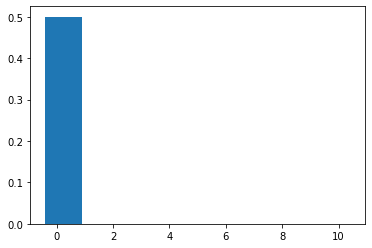

In [33]:
### Robustness checks: focus on big negative mean estimates 
sim_bins_data = SPF_bins
print(str(sum(IndSPF_pk['PRCCPIMean1']<=0.4))+' abnormals')
ct=0
figure=plt.plot()
for id in IndSPF_pk.index[IndSPF_pk['PRCCPIMean1']<-2]:
    print(id)
    print(IndSPF_pk['PRCCPIMean1'][id])
    sim_probs_data= np.flip(np.array([IndSPF['PRCCPI'+str(n)][id]/100 for n in range(11,21)]))
    plt.bar(sim_bins_data[1:],sim_probs_data)
    print(sim_probs_data)
    stats_est=SynDensityStat(SPF_bins,sim_probs_data)
    print(stats_est['mean'])